# Open.Make figure notebook

This is the jupyter notebook which contains the code necessary to replicate the figures as seen in the Open.Make publication.
This code comes paired with the data that was obtained in the control animals of the microstimulation detection task. 

The code integrates the Mouse_Data class as well as several helper and visualization functions to create all figures shown in the manuscript.
All figures include: response time, hit & false positive rate, d prime, raster plots and licking plots

In [2]:
# First we will have to import the dataclass we're using to hold our data, as well as, the helper functions that we'll need.
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *

# We will also import some additional functions from commonly used packages for convenience and plotting.
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy as sp
matplotlib.rcParams.update({'font.size':20, 'font.family':'Times New Roman', 
                            'axes.facecolor':'white' , 'figure.facecolor':'white', 'figure.dpi':100})   
from matplotlib.gridspec import GridSpec


Now we need to load in all the data from the control animals there are x in total 
The Mouse_Data class houses all information from the raw matlab files and has been saved as pandas for ease of access.


In [3]:
# Where do we find the data
root = 'F:/mStim_data/'
path_ext = '/microstim/Session Data/'

# Define which animals are the correct ones to load (i.e. control data)
ctrl_IDs = ['SNA-123601', 'SNA-123602', 'SNA-123599', 'SNA-126687', 'SNA-126688', 'SNA-127100', 'SNA-132298', 'SNA-132303', 'SNA-132305']
ctrl_data = [Mouse_Data(root + ID + path_ext) for ID in ctrl_IDs]

# IDs with videodata TODO Check validity: 'SNA-126687', 'SNA-126688', 'SNA-127100', 'SNA-132298'

# Where do we safe the figures to?
savePath = 'C:/Users/miksc/OneDrive/Documenten/PhD/OpenMake/figures/'

Data will be concatenated; please check validity.
Data will be concatenated; please check validity.


In [22]:
def plot_RT(mouse_data, ax):
    """
    Plot response time (RT) analysis on the provided axis for a list of mouse data sessions.

    Parameters:
        mouse_data (Mouse_Data or list): A Mouse_Data instance or a list of Mouse_Data instances.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis on which to plot the RT data.

    Returns:
        None
    """
    # Initialize dictionary to store response times
    RT_dict = {'stim': [], 'catch': []}

    # Ensure mouse_data is treated as a list even if it's a single instance
    if not isinstance(mouse_data, list):
        mouse_data = [mouse_data]

    # Iterate over each mouse in the list
    for mouse in mouse_data:
        rt_stim_indi = []
        rt_catch_indi = []

        # Iterate over each session of the mouse
        for session_name in mouse.sessions:
            session = mouse.session_data[session_name]

            # Calculate average response time for 'stim' trials
            stim_trials = select_trialType(session, 'test')
            stim_trials = stim_trials.loc[stim_trials['success'] == True]  # Filter successful trials
            rt_stim = np.average(stim_trials['response_t'])
            rt_stim_indi.append(rt_stim)

            # Calculate average response time for 'catch' trials
            catch_trials = select_trialType(session, 'catch')
            catch_trials = catch_trials.loc[catch_trials['success'] == True]  # Filter successful trials
            rt_catch = np.average(catch_trials['response_t'])
            rt_catch_indi.append(rt_catch)

        # Append response times for the current mouse to RT_dict
        RT_dict['stim'].append(rt_stim_indi)
        RT_dict['catch'].append(rt_catch_indi)

    # Calculate average and standard error of the mean (SEM) across mice for each session
    stim_avg = np.average(RT_dict['stim'], axis=0)
    catch_avg = np.average(RT_dict['catch'], axis=0)
    stim_sem = np.std(RT_dict['stim'], axis=0) / np.sqrt(len(mouse_data))
    catch_sem = np.std(RT_dict['catch'], axis=0) / np.sqrt(len(mouse_data))

    # Prepare x-axis values (sessions)
    x = np.arange(len(stim_avg))

    # Plot average response times and add scatter points on the provided axis
    ax.errorbar(x, stim_avg, yerr=stim_sem, c='black', capsize=4, linestyle='none', zorder=1)
    ax.errorbar(x, catch_avg, yerr=catch_sem, c='black', capsize=4, linestyle='none', zorder=1)
    ax.plot(stim_avg, label='Stim', c='green')
    ax.scatter(x, stim_avg, c='green', zorder=2)
    ax.plot(catch_avg, label='Catch', c='red')
    ax.scatter(x, catch_avg, c='red', zorder=2)

    # Set plot limits, ticks, labels, and display the legend
    ax.set_ylim([0.3, 0.9])
    ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ax.set_xlim([-0.10, 3.10])
    ax.set_xticks(x)
    ax.set_xticklabels([1, 2, 3, 4])
    ax.set_ylabel('Response time (s)')
    ax.set_xlabel('Session')

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def get_RTvariances(mouse_data):
    ''' calculates all different types of variances in response time and returns it as a dict with keys the type of variance
    and the value a list of that variance value for each session.
    '''
    # Holder of the data as a list
    RTvariences = {'std':[], 
                   'var':[],
                   'cv':[],
                   'sem':[]}
    
    stimRTs = get_RTs(mouse_data, trial_type=1)

    # Now calculate and append
    for i, RTs in enumerate(stimRTs):
        RTvariences['std'].append(np.std(RTs))
        RTvariences['var'].append(np.var(RTs))
        RTvariences['cv'].append(np.std(RTs)/np.mean(RTs) * 100)
        RTvariences['sem'].append(np.std(RTs)/np.sqrt(len(RTs)))        

    return RTvariences

def aggregate_RTvariances(data_list):
    '''
    Aggregates variance data from multiple mice into a single dictionary.
    
    Args:
    data_list (list): List of mouse data dictionaries.
    
    Returns:
    dict: A dictionary with aggregated variance data.
    '''
    aggregated_data = {'std': [], 
                       'var': [],
                       'cv': [],
                       'sem': []}

    for mouse_data in data_list:
        RTvariance = get_RTvariances(mouse_data)

        for key, values in RTvariance.items():
            aggregated_data[key].append(values)
    
    return aggregated_data

def plot_RT_SEM(mouse_data, ax):
    """
    Plots the SEM (Standard Error of the Mean) of Response Time (RT) across sessions for 'stim' trials.

    Parameters:
        mouse_data (list): A list of Mouse_Data instances.
        ax (matplotlib.axes.Axes): The axis on which to plot the SEM of RT.
    
    Returns:
        None
    """
    # Aggregate RT variances across multiple mice
    aggregated_data = aggregate_RTvariances(mouse_data)
    
    # Calculate the mean and standard error of the SEM of RT across sessions
    data = np.mean(aggregated_data['sem'], axis=0)  # Average SEM for each session
    data_std = np.std(aggregated_data['sem'], axis=0) / np.sqrt(len(aggregated_data['sem']))  # Standard error for each session
    
    # Plot the SEM of RT as a bar chart on the provided axis
    ax.bar(x=np.arange(len(data)), height=data, color='gray', yerr=data_std, capsize=2)
    ax.set_xticks(np.arange(len(data)))
    ax.set_yticks([0, 0.04, 0.08])
    ax.set_ylabel('SEM of RT')
    ax.set_xlabel('Session')
    
    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


## Figure 2 
### Description of behaviour, what does a trained animal look like: d', P(Hit), RT, RT_SEM


TypeError: 'Mouse_Data' object is not iterable

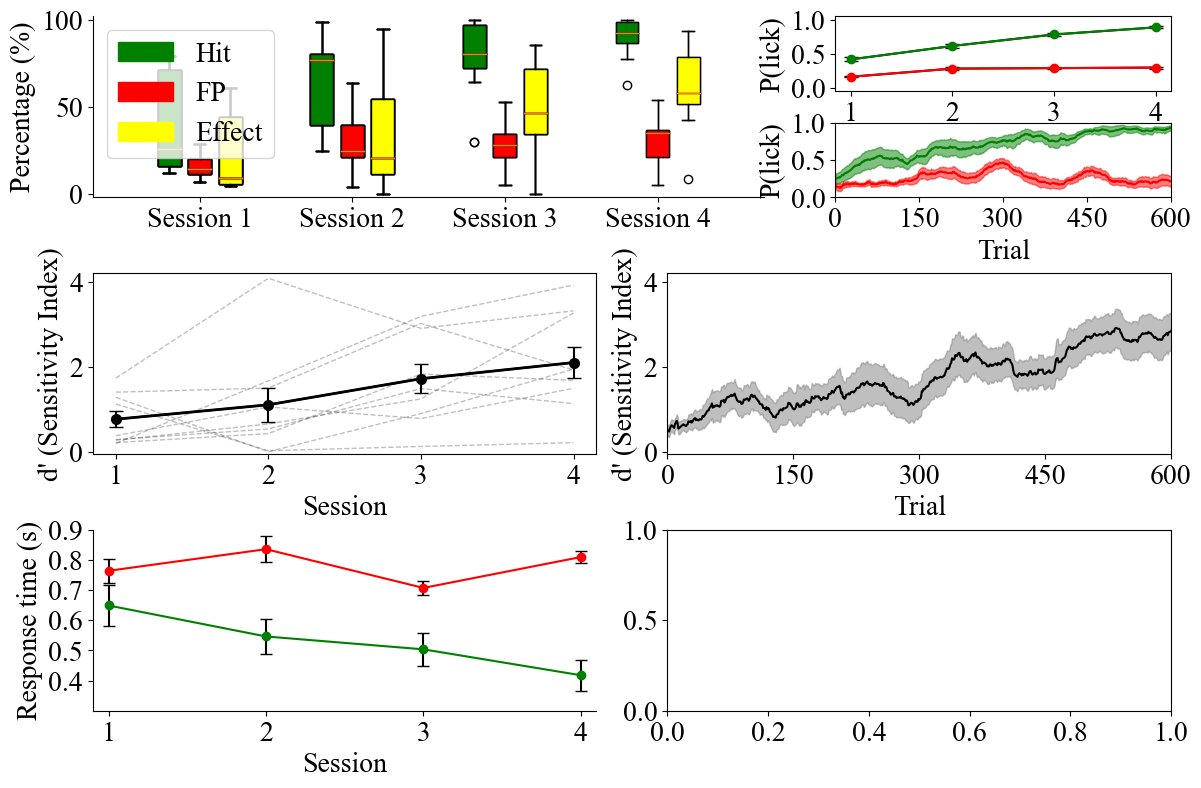

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure with a specified size
fig = plt.figure(figsize=(12, 8))

# Create the outer GridSpec with 3 rows and 2 columns
outer = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

# Create subplots in the outer GridSpec
ax1 = fig.add_subplot(outer[0, 0])  # Large plot on the top left

# Create inner GridSpec for the top right column (2 rows, 1 column)
top_right_inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0, 1])

# Create subplots in the top right inner GridSpec
ax3 = fig.add_subplot(top_right_inner[0, 0])
ax4 = fig.add_subplot(top_right_inner[1, 0])

# Create inner GridSpec for the middle row (1 row, 2 columns)
middle_row_inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1, :])

# Create subplots in the middle row inner GridSpec
ax2 = fig.add_subplot(middle_row_inner[0, 0])
ax5 = fig.add_subplot(middle_row_inner[0, 1])

# Create inner GridSpec for the bottom row (1 row, 2 columns)
bottom_row_inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[2, :])

# Create subplots in the bottom row inner GridSpec
ax6 = fig.add_subplot(bottom_row_inner[0, 0])
ax7 = fig.add_subplot(bottom_row_inner[0, 1])

plt.tight_layout()

'''Boxplot'''
# Determine number of sessions and prepare x-axis ticks
bigdict = {'hit_rate':[], 'FP_rate':[], 'effect_rate':[]}
n_sessions = np.max([len(ctrl.sessions) for ctrl in ctrl_data])
xticks = np.arange(0, 4, 1)
massivedict = {n:bigdict.copy() for n in xticks}

# Get the data to plot
# For each session get the rate for each animal
for n_session in xticks:
    bigdict = {'hit_rate':[], 'FP_rate':[], 'effect_rate':[]}
    for ctrl in ctrl_data:
        if n_session >= len(ctrl.sessions):
            continue
        session = ctrl.sessions[n_session]
        testData = select_trialType(ctrl.session_data[session], 'test')
        catchData = select_trialType(ctrl.session_data[session], 'catch')

        # Gather data about microstim and catch trials
        mHit, mMiss = get_hitnmiss(testData)
        mTotal = mHit + mMiss
        cHit, cMiss = get_hitnmiss(catchData)
        cTotal = cHit + cMiss

        # For every individual animal during each session calculate the rate and add to the big dict
        if mTotal > 0 and cTotal > 0:
            hit_rate = mHit / mTotal * 100
            FP_rate = cHit / cTotal * 100
            effect_rate = hit_rate - FP_rate
            bigdict['hit_rate'].append(hit_rate)
            bigdict['FP_rate'].append(FP_rate)
            if effect_rate < 0:
                        # print(effect_rate)
                        effect_rate = 0
            bigdict['effect_rate'].append(effect_rate)
    
    # Store bigdict in massivedict
    massivedict[n_session] = bigdict
    # Prepare data for boxplots
    data = []
    colors = []
    for n_session in xticks:
        data.append(massivedict[n_session]['hit_rate'])
        data.append(massivedict[n_session]['FP_rate'])
        data.append(massivedict[n_session]['effect_rate'])
        colors.extend(['green', 'red', 'yellow'])

    # Create positions for boxplots
    positions = np.arange(len(data)) // 3 + (np.arange(len(data)) % 3) * 0.2 - 0.2
    # Plot boxplots
    box = ax1.boxplot(data, positions=positions, widths=0.15, patch_artist=True, showfliers=False)
    for median in box['medians']:
        median.set_color('black')
    # Color each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # Set x-ticks for grouped boxplots
    ax1.set_xticks(np.arange(n_sessions))
    ax1.set_xticklabels([f'Session {i+1}' for i in xticks], rotation=45)
    # Create positions for boxplots
    positions = np.arange(len(data)) // 3 + (np.arange(len(data)) % 3) * 0.2 - 0.2
    # Plot boxplots
    box = ax1.boxplot(data, positions=positions, widths=0.15, patch_artist=True)
    # Color each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # Set x-ticks for grouped boxplots
    ax1.set_xticks(np.arange(n_sessions))
    ax1.set_xticklabels([f'Session {i+1}' for i in xticks], rotation=0)
# Formatting
ax1.set_ylabel('Percentage (%)')
ax1.set_ylim([-2, 102])
# Add legend
green_patch = matplotlib.patches.Patch(color='green', label='Hit')
red_patch = matplotlib.patches.Patch(color='red', label='FP')
yellow_patch = matplotlib.patches.Patch(color='yellow', label='Effect')
ax1.legend(handles=[green_patch, red_patch, yellow_patch], loc='upper left')
# Remove spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

'''PLICK'''
mstimP_list = []
catchP_list = []
n=len(ctrl_data)

for data in ctrl_data:
    # Get the stimP and catch P for each session
    mstimP, catchP = get_PLick(data, catchInf=True, binsize=0)
    mstimP_list.append(mstimP)
    catchP_list.append(catchP)

# Now that we have a nested list with all Plicks for each session get the average
mstimP = np.mean(mstimP_list, axis=0)
mstim_std = np.std(mstimP_list, axis=0)
catchP = np.mean(catchP_list, axis=0)
catch_std = np.std(catchP_list, axis=0)


# Plot microstimulation lick probability ('mstimP') in blueviolet color and ('catchP') in gray color
ax3.plot(mstimP, color='green', alpha=1, label=r'$\mu$Stim', zorder=2)
ax3.plot(catchP, color='red', alpha=1, label='Catch', zorder=2) 
x = np.arange(0, len(mstimP), 1)
ax3.scatter(x, mstimP, c='green', zorder=2)  # Scatter plot for 'stim' trials
ax3.scatter(x, catchP, c='red', zorder=2)  # Scatter plot for 'catch' trials

# Set plot title and labels
# ax3.set_title(title)  # Set the plot title to mouse id (if desired)
ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels([1, 2, 3, 4])  # Set custom x-axis tick labels
ax3.set_xlabel('Session')  # Set x-axis label to 'Session'
ax3.set_ylabel('P(lick)')  # Set y-axis label to 'P(lick)'

ax3.set_ylim([-0.05, 1.05])
ax3.set_yticks([0,0.5,1])

# Plot std
ax3.errorbar([0,1,2,3], mstimP, yerr=mstim_std/n, c='black', capsize=5, zorder=1)
ax3.errorbar([0,1,2,3], catchP, yerr=catch_std/n, c='black', capsize=5, zorder=1)


'''PLICK TRIAL'''
mstim_list = []
catch_list = []
for data in ctrl_data:
    mstim, catch = get_PLick(data, binsize=50)
    mstim_list.append(mstim)
    catch_list.append(catch)
mstim_list = extend_lists(mstim_list)
catch_list = extend_lists(catch_list)

# Calculate values
mstim_avg = np.mean(mstim_list, axis=0)
mstim_sem = np.std(mstim_list, axis=0) / np.sqrt(len(ctrl_data))
catch_avg = np.mean(catch_list, axis=0)
catch_sem = np.std(catch_list, axis=0) / np.sqrt(len(ctrl_data))

ax4.plot(mstim_avg, color='green')
ax4.plot(catch_avg, color='red')
ax4.fill_between(np.arange(0, len(mstim_avg), 1), mstim_avg-mstim_sem, mstim_avg+mstim_sem, alpha=0.5, color='green')
ax4.fill_between(np.arange(0, len(catch_avg), 1), catch_avg-catch_sem, catch_avg+catch_sem, alpha=0.5, color='red')

# Format
ax4.set_xlim([0, 600])
ax4.set_ylabel('P(lick)')
ax4.set_xlabel('Trial')
ax4.set_xticks([0,150,300,450,600])
ax4.set_yticks([0,0.5,1])
ax4.set_ylim([0,1])

'''DPRIME'''
mega_d = []
for mouse in ctrl_data:
    d_prime_list = calc_d_prime(mouse)
    mega_d.append(d_prime_list)

avg_list, std_list = get_avg_std_threshold(mega_d, max_sessions=4)

# Ploterdeplot
# Individual lines and points
[ax2.plot(d_prime, c='black', alpha=0.25, linestyle='--', linewidth=1) for d_prime in mega_d] 
# [ax2.scatter(x=[0,1,2,3],y=d_prime, c='black', alpha=0.3) for d_prime in mega_d]  
# Average
ax2.plot(avg_list, c='black', linewidth=2)
ax2.scatter(x=[0,1,2,3], y=avg_list, c='black', linewidths=2)

# SEM
sem_list = np.array(std_list)/np.sqrt(len(ctrl_data))
if len(ctrl_data) > 1:
    ax2.errorbar([0,1,2,3], avg_list, yerr=sem_list, c='black',capsize=5)

# Format
ax2.set_ylim([-0.05,4.2])
ax2.set_ylabel('d\' (Sensitivity Index)')
ax2.set_xticks([0,1,2,3], [1,2,3,4])
ax2.set_xlabel('Session')

'''dprim trials'''
dpall = []
for mouse in ctrl_data:
    dplist = calc_d_prime(mouse, binsize=50)
    dpall.append(dplist)
    # ax5.plot(dplist, color='gray')
    ax5.set_xlim([0,600])
dpall = extend_lists(dpall)
d_mean = np.mean(dpall, axis=0)

ax5.plot(d_mean, color='black')
# Add SEM
d_std = np.std(dpall, axis=0)
d_sem = d_std / np.sqrt(len(ctrl_data))
y_min = np.subtract(d_mean, d_sem)
y_max = np.add(d_mean, d_sem)
x = np.arange(0, len(d_mean), 1)
ax5.fill_between(x, y_min, y_max, alpha=0.5, color='gray')
ax5.set_ylabel('d\' (Sensitivity Index)')
ax5.set_xlabel('Trial')
ax5.set_xticks([0,150,300,450,600])
ax5.set_xlim([0,600])
ax5.set_ylim([-0.05,4.2])

# Response time
# Call plot_RT to plot on ax6
plot_RT(ctrl_data, ax6)


# RT variance:
# Example usage within your existing figure layout
plot_RT_SEM(ctrl_data, ax7)  # Plot on ax7



# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
# fig.savefig(fname=savePath + 'figure2_python.svg', dpi=600)


# Fig 1
The first figure we will make shows the hit and false positive rate over sessions of all mice
We adapt the blabla function from the visualization.py file to depict the progression. 

-1.0668563300142253
-4.599750401141023
Data is not normally distributed. Using Wilcox
4.0 0.02734375
Statistics: stat=4.0, p=0.02734375


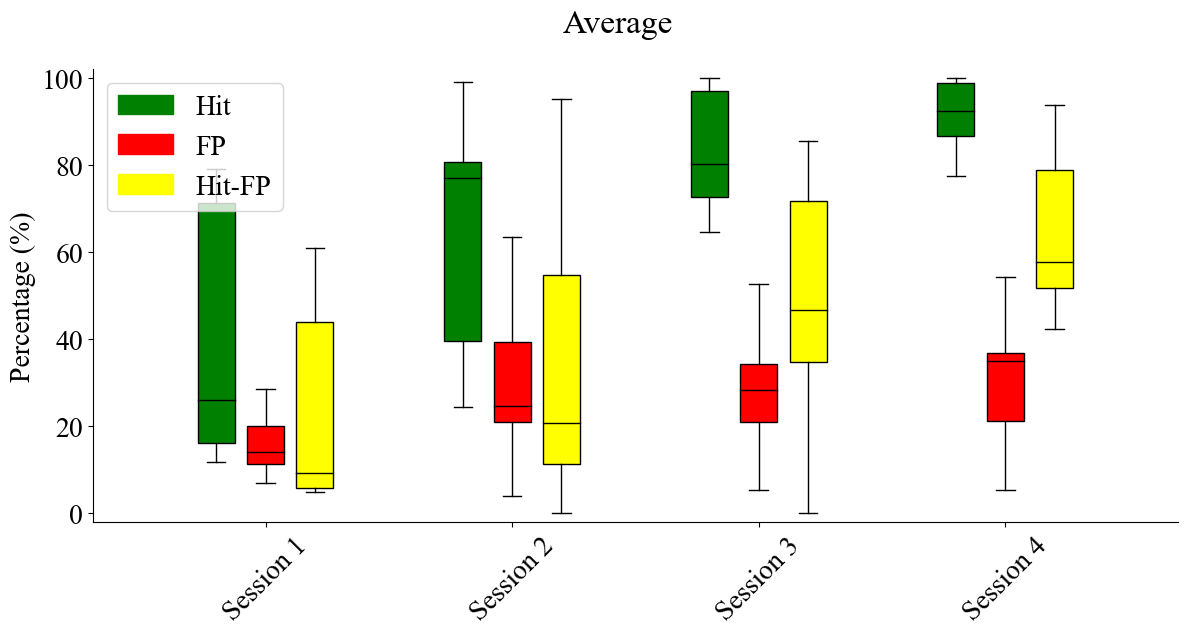

In [32]:
def plot_performanceboxplot(mouse_data, average=False):
    ''' Boxplot showing the percentage hits, false positives and hits-FP for each session of an individual animal

    Parameters:
        mouse_data (list or Mouse_Data): A (list of) Mouse_Data instances.
        average (bool, optional): If True, plot average performance over sessions.

    Returns:
        matplotlib.pyplot 
    '''
    # Check input and initialize data structures for averaging
    if average:
        if not isinstance(mouse_data, list):
            raise TypeError('mouse_data should be a list of Mouse_Data Classes')
        # Determine number of sessions and prepare x-axis ticks
        bigdict = {'hit_rate':[], 'FP_rate':[], 'effect_rate':[]}
        n_sessions = np.max([len(mouse.sessions) for mouse in mouse_data])
        xticks = np.arange(0, n_sessions, 1)
        massivedict = {n:bigdict.copy() for n in xticks}
        title = 'Average'
    # Prepare data for individual mouse plot
    else:   
        title = mouse_data.id
        n_sessions = len(mouse_data.sessions)
        xticks = np.arange(0, n_sessions, 1)
        
    # Set plot 
    fig, axs = plt.subplots(1, figsize=(14, 6))
    fig.patch.set_facecolor('white')

    # Get the data to plot
    if average:
        # For each session get the rate for each animal
        for n_session in xticks:
            bigdict = {'hit_rate':[], 'FP_rate':[], 'effect_rate':[]}
            for mouse in mouse_data:
                if n_session >= len(mouse.sessions):
                    continue
                session = mouse.sessions[n_session]
                testData = select_trialType(mouse.session_data[session], 'test')
                catchData = select_trialType(mouse.session_data[session], 'catch')

                # Gather data about microstim and catch trials
                mHit, mMiss = get_hitnmiss(testData)
                mTotal = mHit + mMiss
                cHit, cMiss = get_hitnmiss(catchData)
                cTotal = cHit + cMiss

                # For every individual animal during each session calculate the rate and add to the big dict
                if mTotal > 0 and cTotal > 0:
                    hit_rate = mHit / mTotal * 100
                    FP_rate = cHit / cTotal * 100
                    effect_rate = hit_rate - FP_rate
                    if effect_rate < 0:
                        print(effect_rate)
                        effect_rate = 0
                    bigdict['hit_rate'].append(hit_rate)
                    bigdict['FP_rate'].append(FP_rate)
                    bigdict['effect_rate'].append(effect_rate)
            
            # Store bigdict in massivedict
            massivedict[n_session] = bigdict

        # Prepare data for boxplots
        data = []
        colors = []
        for n_session in xticks:
            data.append(massivedict[n_session]['hit_rate'])
            data.append(massivedict[n_session]['FP_rate'])
            data.append(massivedict[n_session]['effect_rate'])
            colors.extend(['green', 'red', 'yellow'])

        # Create positions for boxplots
        positions = np.arange(len(data)) // 3 + (np.arange(len(data)) % 3) * 0.2 - 0.2

        # Plot boxplots
        box = axs.boxplot(data, positions=positions, widths=0.15, patch_artist=True, showfliers=False)

        for median in box['medians']:
            median.set_color('black')

        # Color each box
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        # Set x-ticks for grouped boxplots
        axs.set_xticks(np.arange(n_sessions))
        axs.set_xticklabels([f'Session {i+1}' for i in xticks], rotation=45)
        
        # Perform and print statistics
        if n_sessions > 3:
            stat, p = do_statistics(massivedict[0]['effect_rate'], massivedict[3]['effect_rate'])
            print(f'Statistics: stat={stat}, p={p}')

    # For plotting the data of an individual animal
    else:
        data = []
        colors = []
        for n_session in xticks:
            mouse = mouse_data
            session = mouse.sessions[n_session]
            testData = select_trialType(mouse.session_data[session], 'test')
            catchData = select_trialType(mouse.session_data[session], 'catch')

            # Gather data about microstim and catch trials
            mHit, mMiss = get_hitnmiss(testData)
            mTotal = mHit + mMiss
            cHit, cMiss = get_hitnmiss(catchData)
            cTotal = cHit + cMiss

            # For every individual animal during each session calculate the rate
            if mTotal > 0 and cTotal > 0:
                hit_rate = mHit / mTotal * 100
                FP_rate = cHit / cTotal * 100
                effect_rate = hit_rate - FP_rate
                
                data.append([hit_rate])
                data.append([FP_rate])
                data.append([effect_rate])
                colors.extend(['green', 'red', 'yellow'])

        # Create positions for boxplots
        positions = np.arange(len(data)) // 3 + (np.arange(len(data)) % 3) * 0.2 - 0.2

        # Plot boxplots
        box = axs.boxplot(data, positions=positions, widths=0.15, patch_artist=True)

        # Color each box
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set x-ticks for grouped boxplots
        axs.set_xticks(np.arange(n_sessions))
        axs.set_xticklabels([f'Session {i+1}' for i in xticks], rotation=45)

    # Formatting
    fig.suptitle(title, y=0.98)  
    axs.set_ylabel('Percentage (%)')
    axs.set_ylim([-2, 102])
    
    # Add legend
    green_patch = matplotlib.patches.Patch(color='green', label='Hit')
    red_patch = matplotlib.patches.Patch(color='red', label='FP')
    yellow_patch = matplotlib.patches.Patch(color='yellow', label='Hit-FP')
    axs.legend(handles=[green_patch, red_patch, yellow_patch], loc='upper left')

    # Remove spines
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    plt.show()
    return fig

# Example usage (ensure that you have the necessary data and functions defined):
fig = plot_performanceboxplot(ctrl_data, average=True)
# fig.savefig(fname=savePath + 'boxplot.jpg', dpi=600)

Next up it the absolute response time

[0.06775754 0.05771512 0.05481317 0.05197611]


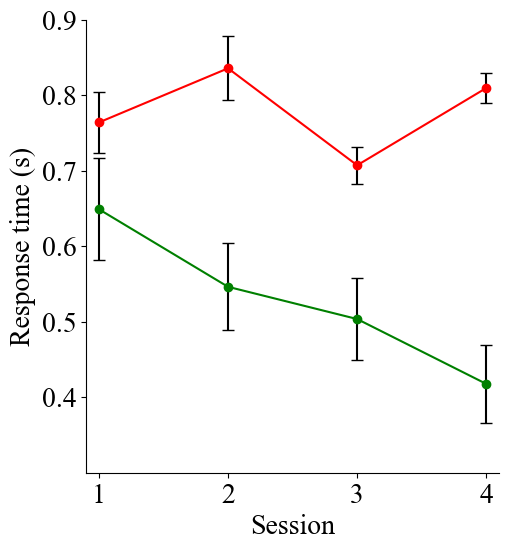

In [ ]:
def plot_RT(mouse_data):
    """
    Plot response time (RT) analysis for a list of mouse data sessions.

    This function calculates and visualizes the average response times for 'stim' and 'catch' trials across
    multiple sessions of one or more mice.

    Parameters:
        mouse_data (Mouse_Data or list): A Mouse_Data instance or a list of Mouse_Data instances.

    Returns:
        None
    """
    # Initialize dictionary to store response times
    RT_dict = {'stim': [], 'catch': []}

    # Ensure mouse_data is treated as a list even if it's a single instance
    if not isinstance(mouse_data, list):
        mouse_data = [mouse_data]

    # Iterate over each mouse in the list
    for mouse in mouse_data:
        rt_stim_indi = []
        rt_catch_indi = []

        # Iterate over each session of the mouse
        for session_name in mouse.sessions:
            session = mouse.session_data[session_name]

            # Calculate average response time for 'stim' trials
            stim_trials = select_trialType(session, 'test')
            stim_trials = stim_trials.loc[stim_trials['success'] == True]  # Filter successful trials
            rt_stim = np.average(stim_trials['response_t'])
            rt_stim_indi.append(rt_stim)

            # Calculate average response time for 'catch' trials
            catch_trials = select_trialType(session, 'catch')
            catch_trials = catch_trials.loc[catch_trials['success'] == True]  # Filter successful trials
            rt_catch = np.average(catch_trials['response_t'])
            rt_catch_indi.append(rt_catch)

        # Append response times for the current mouse to RT_dict
        RT_dict['stim'].append(rt_stim_indi)
        RT_dict['catch'].append(rt_catch_indi)

    # Calculate average and standard deviation across mice for each session
    stim_avg = np.average(RT_dict['stim'], axis=0)
    catch_avg = np.average(RT_dict['catch'], axis=0)
    stim_std = np.std(RT_dict['stim'], axis=0)
    catch_std = np.std(RT_dict['catch'], axis=0)
    stim_sem = stim_std/np.sqrt(len(mouse_data))
    catch_sem = catch_std/np.sqrt(len(mouse_data))

    # Prepare x-axis values (sessions)
    x = np.arange(len(stim_avg))
    
    # Create a new figure and axis for plotting
    fig, ax = plt.subplots(figsize=(5.33, 6))

    # If multiple mice are plotted, show error bars representing standard deviation
    #SEM
    ax.errorbar(x, stim_avg, yerr=stim_sem, c='black', capsize=4, linestyle='none', zorder=1)
    ax.errorbar(x, catch_avg, yerr=catch_sem, c='black', capsize=4, linestyle='none', zorder=1)
    #STD
    # ax.errorbar(x, stim_avg, yerr=stim_std, c='green', capsize=5, linestyle='none)
    # ax.errorbar(x, catch_avg, yerr=catch_std, c='red', capsize=5, linestyle='none)

    # Plot average response times and add scatter points
    ax.plot(stim_avg, label='Stim', c='green')
    ax.scatter(x, stim_avg, c='green', zorder=2)  # Scatter plot for 'stim' trials
    ax.plot(catch_avg, label='Catch', c='red')
    ax.scatter(x, catch_avg, c='red', zorder=2)  # Scatter plot for 'catch' trials


    # Set plot limits, ticks, labels, and display the legend
    ax.set_ylim([0.3, 0.9])
    ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
    # ax.set_yticks(np.arange(0, 1.2, 0.2))
    # ax.set_xlim([-0.5, len(stim_avg) - 0.5])  # Adjust x-axis limits based on number of sessions
    ax.set_xlim([-0.10,3.10])
    ax.set_xticks(x)
    ax.set_xticklabels([1,2,3,4])
    ax.set_ylabel('Response time (s)')
    ax.set_xlabel('Session')

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Display the plot
    plt.show()

    return fig

fig = plot_RT(ctrl_data)
# fig.savefig(fname=savePath + 'RT.svg', dpi=600)

In [13]:
def plot_d_prime(mouse_data):
    if not isinstance(mouse_data, list):
        mouse_data = [mouse_data]
    mega_d = []
    for mouse in mouse_data:
        d_prime_list = calc_d_prime(mouse)
        mega_d.append(d_prime_list)

    avg_list, std_list = get_avg_std_threshold(mega_d, max_sessions=4)

    # Ploterdeplot
    fig = plt.figure(figsize=(7,4))
    # Individual lines and points
    [plt.plot(d_prime, c='black', alpha=0.25, linestyle='--', linewidth=1) for d_prime in mega_d] 
    # [plt.scatter(x=[0,1,2,3],y=d_prime, c='black', alpha=0.3) for d_prime in mega_d]  
    # Average
    plt.plot(avg_list, c='black', linewidth=2)
    plt.scatter(x=[0,1,2,3], y=avg_list, c='black', linewidths=2)

    # SEM
    sem_list = np.array(std_list)/np.sqrt(len(mouse_data))
    if len(mouse_data) > 1:
        plt.errorbar([0,1,2,3], avg_list, yerr=sem_list, c='black',capsize=5)

    # Format
    plt.ylim([-0.05,4.2])
    plt.ylabel('d\' (Sensitivity Index)')
    plt.xticks([0,1,2,3], [1,2,3,4])
    plt.xlabel('Session')
    plt.show()
    return fig

fig = plot_d_prime(ctrl_data)

# fig.savefig(fname=savePath + 'dprime.svg', dpi=600)

TypeError: get_PLick() got an unexpected keyword argument 'binsize'

In [8]:
# import seaborn as sns
# mega_d = []
# for mouse in ctrl_data:
#     d_prime = calc_d_prime(mouse)
#     mega_d.append(d_prime)

# Different plots for testing
# plt.violinplot(np.array(mega_d))
# plt.show()
# sns.stripplot(np.array(mega_d), jitter=True)
# plt.show()
# sns.swarmplot(np.array(mega_d))
# plt.show()
# sns.pointplot(np.array(mega_d))
# plt.show()

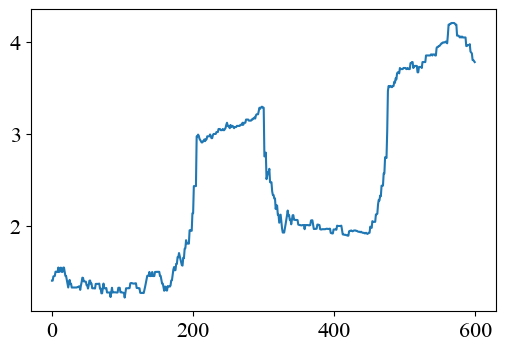

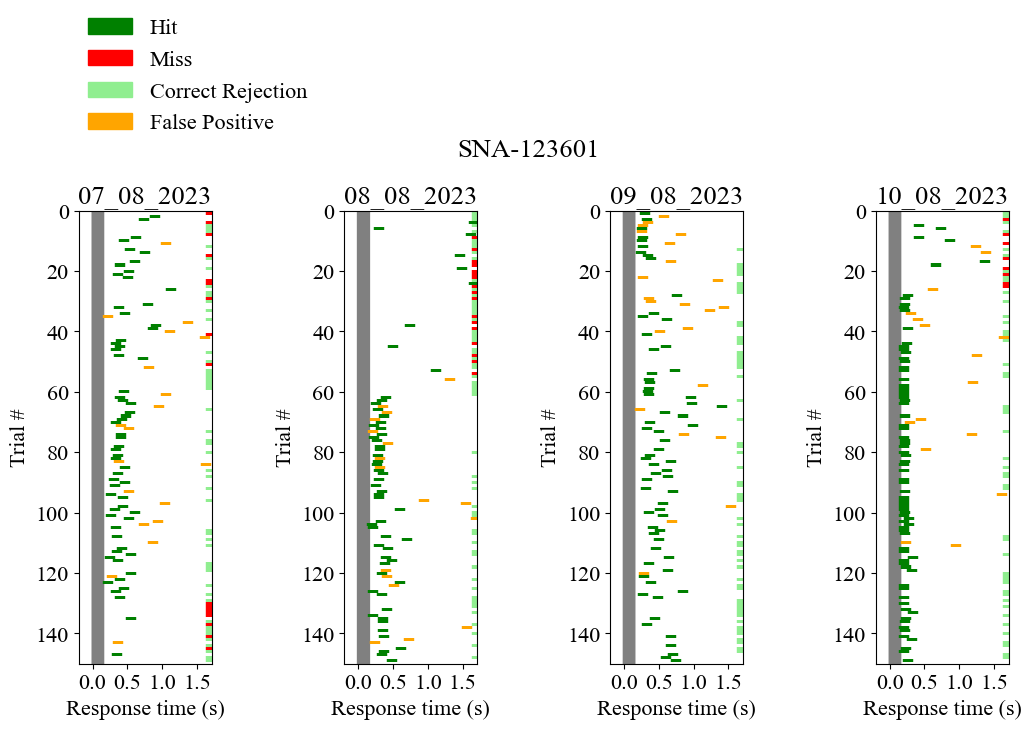

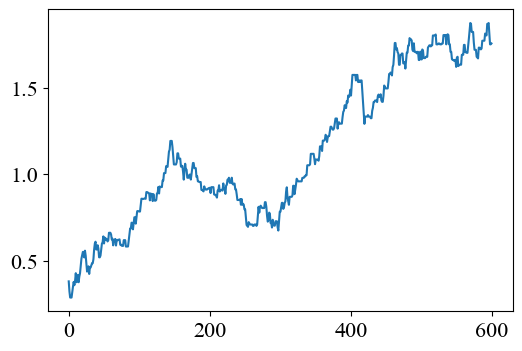

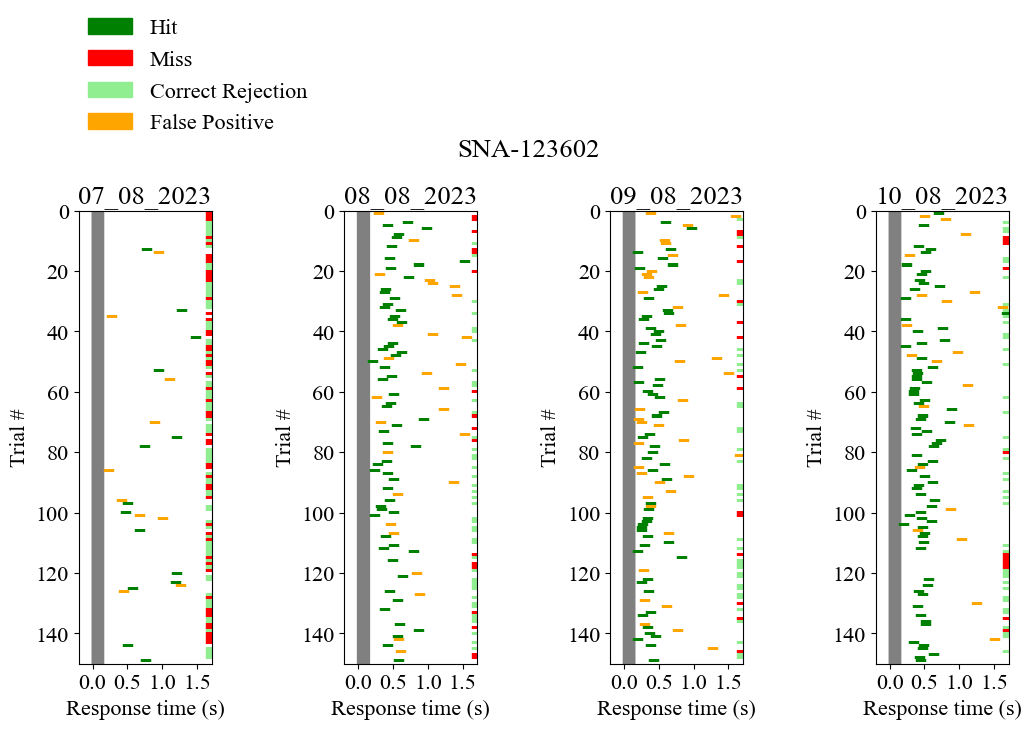

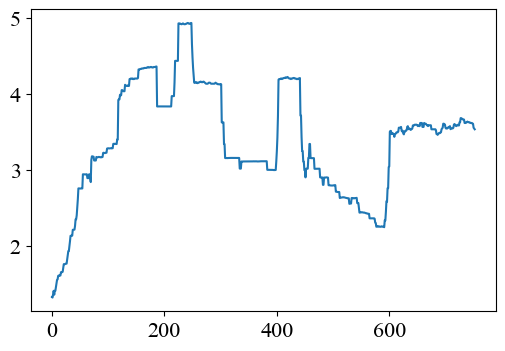

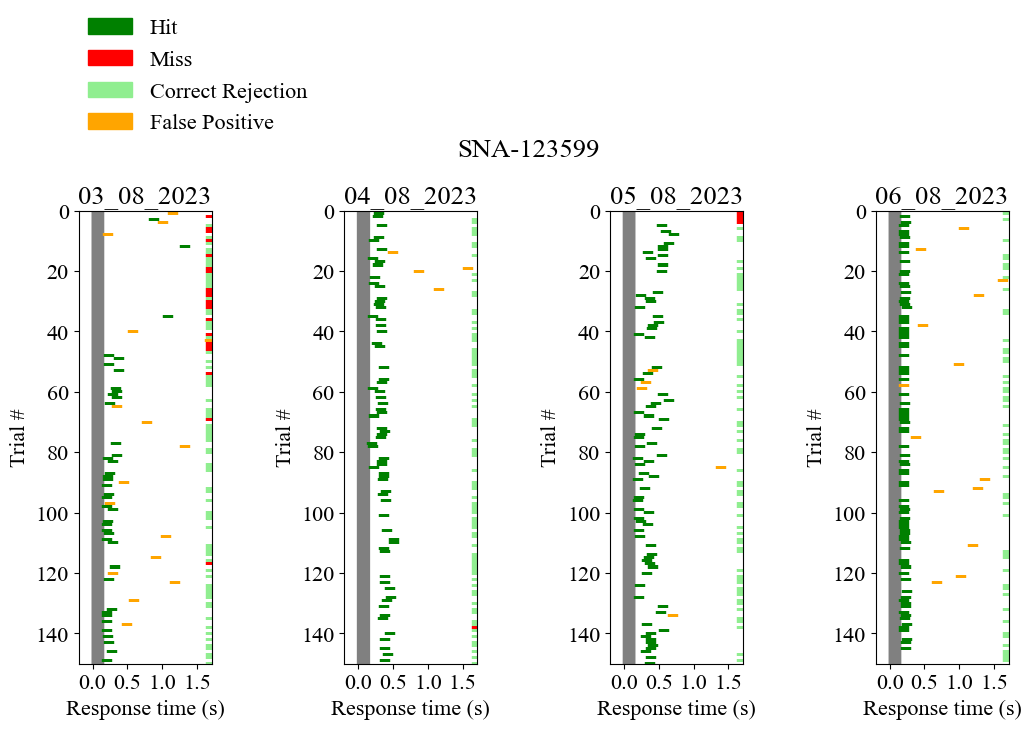

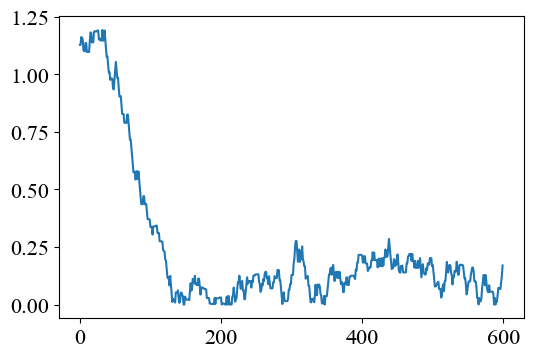

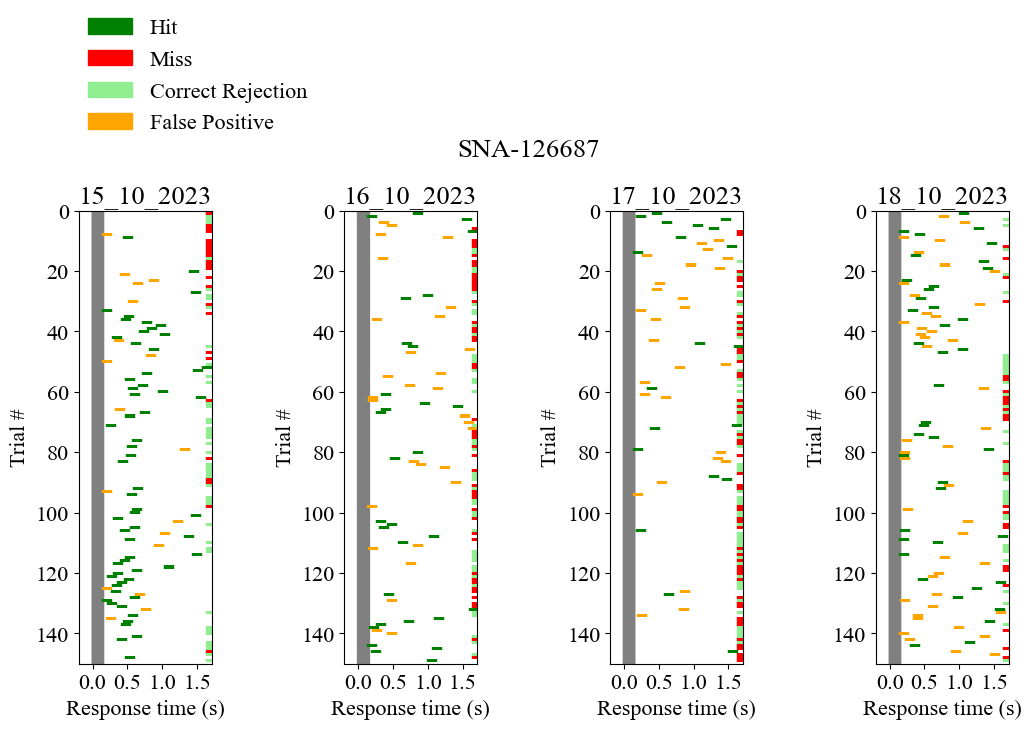

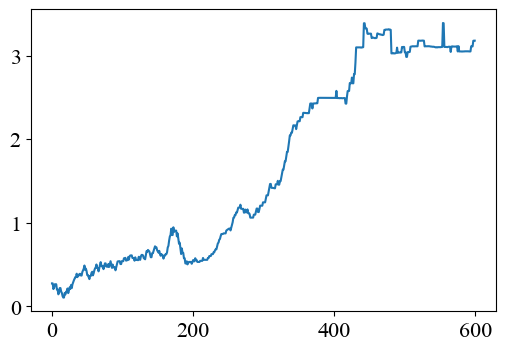

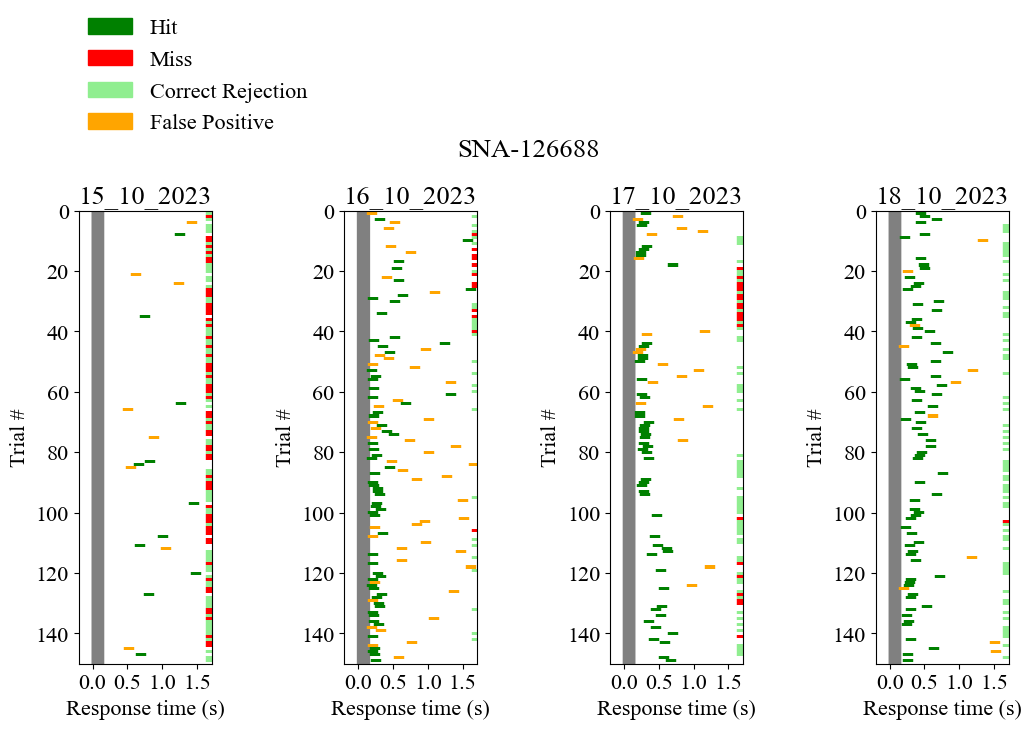

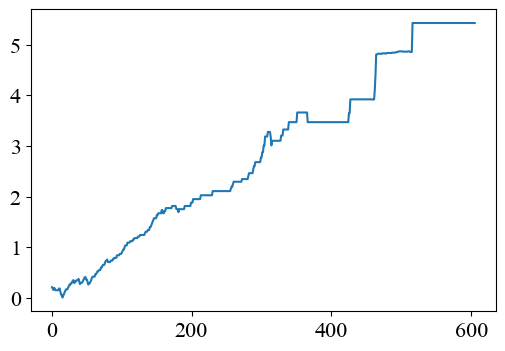

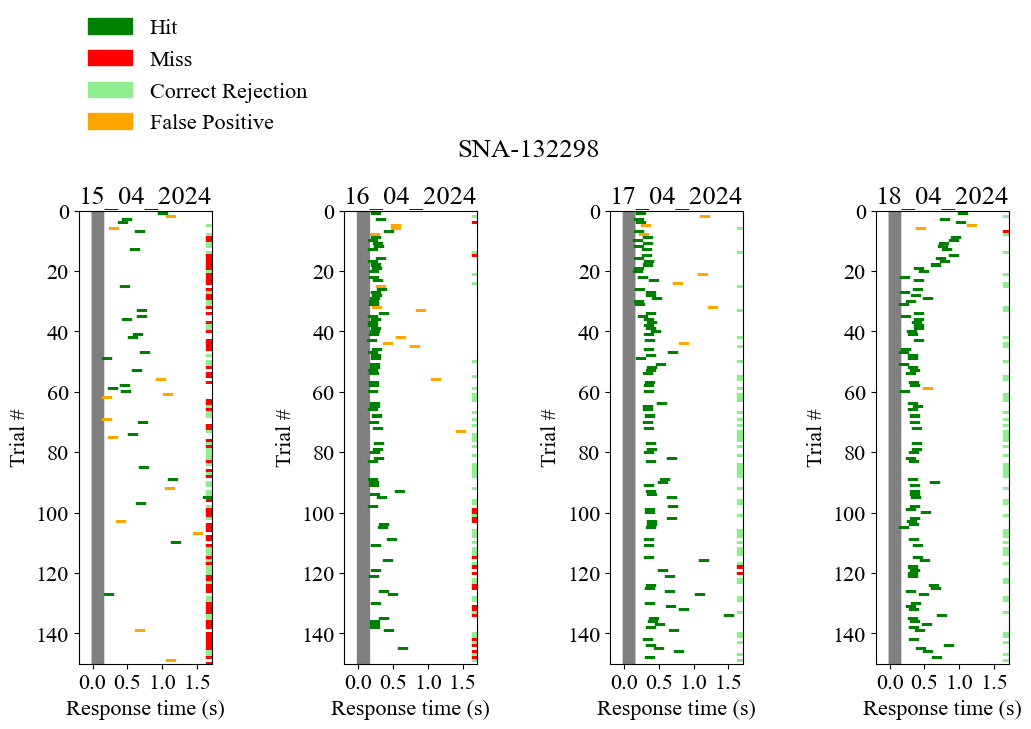

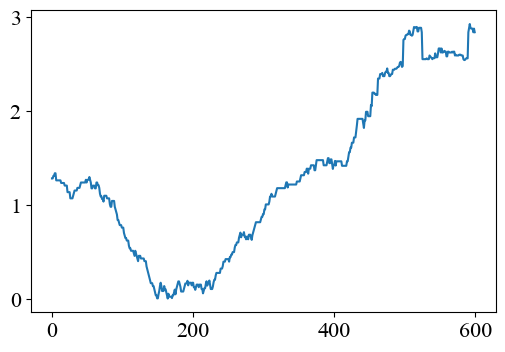

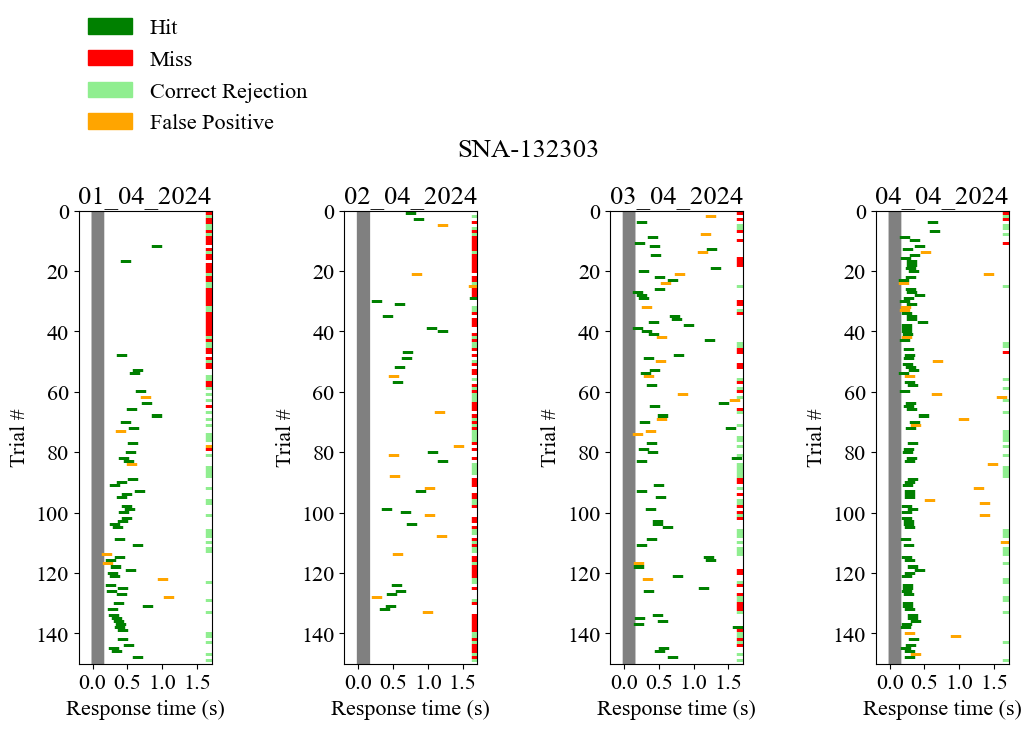

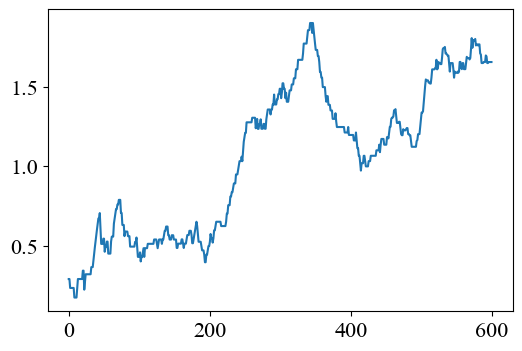

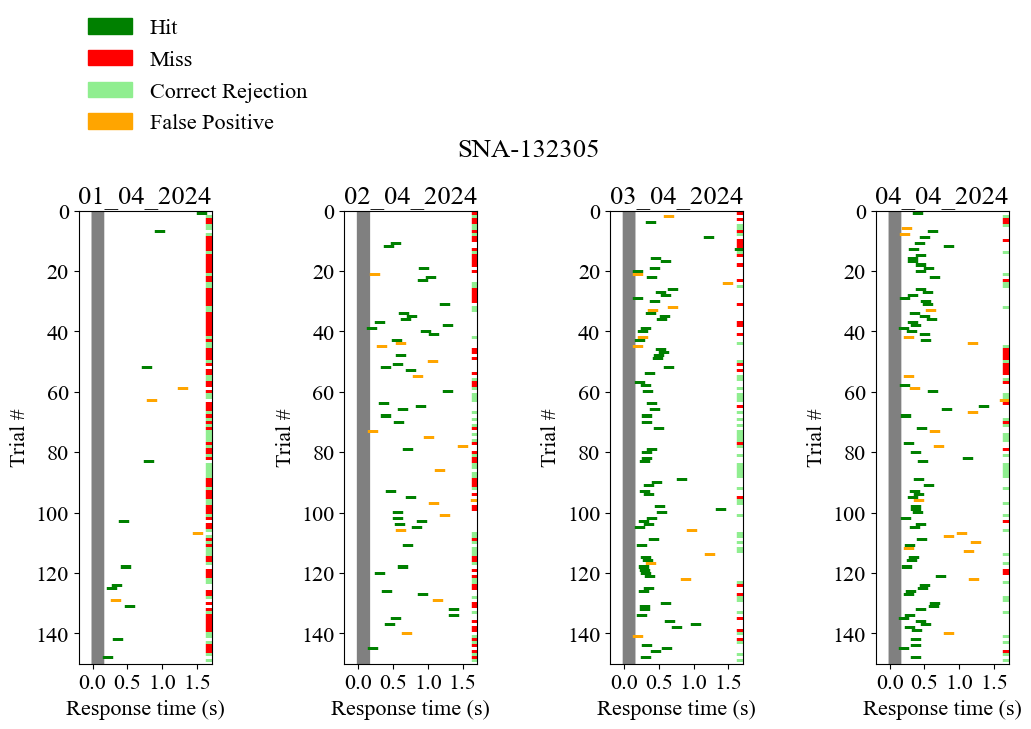

In [37]:
# old? 

# x = get_PLick(ctrl_data[4], binsize=100)
# plt.plot(x[0], color='green')
# plt.plot(x[1], color='red')
# plt.xlim([0,600])
# plt.show()


def plot_raster_rt(mouse_data, save=False, peak=False):
    ''' Creates a figure containing rasterplots of the trial response time.

        INPUT:
            mouse_data(Mouse_Data): Dataclass with attributes like id, sessions,.session_data and concatenated data
            save(bool): prompts the user for destination folder path
            peak(bool): if true only two session rasterplots will be created
        OUTPUT:
            raster_rt_plot(matplotlib.plt): either a plot is shown or saved
    '''
    # Check for peaking allowing the user to only see the plots of the first 2 sessions
    if peak:
        n_sessions = 2
    else:
        n_sessions = len(mouse_data.sessions)
    # Set figure basics 
    fig, axs = plt.subplots(1, n_sessions, figsize=(12, 6)) # Size plot according to the number of sessions
    plt.subplots_adjust(wspace=1.) 
    fig.patch.set_facecolor('white')
    fig.suptitle(str(mouse_data.id), y=1.0)
    
    # Create legend patches
    # gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')
    orange_patch = matplotlib.patches.Patch(color='orange', label='False Positive')
    red_patch = matplotlib.patches.Patch(color='red', label='Miss')
    green_patch = matplotlib.patches.Patch(color='green', label='Hit')
    lightgreen_patch = matplotlib.patches.Patch(color='lightgreen', label='Correct Rejection')
    
    # Get and plot data for every session
    for idx, session in enumerate(mouse_data.sessions):
        if peak and idx == n_sessions:
            break
        colors = []
        
        # For pairing only pair and mix data are important
        # if catch:
        select_data = mouse_data.session_data[session].loc[(mouse_data.session_data[session]['trialType'] == 2)|(mouse_data.session_data[session]['trialType'] == 1)|(mouse_data.session_data[session]['trialType'] == 'pairData')]        
        patches = [green_patch, red_patch, lightgreen_patch, orange_patch]
        
        # Aquire response time, xticks and datatype
        rt_full = select_data['response_t']
        x = np.arange(0, len(rt_full), 1) # Initiate x-axis for plotting
        rt = [[rt] for rt in rt_full] # plt.eventplot requires values as list to ascribe different offsets
        # dtype = [[dtype] for dtype in select_data['trialType']]

        # Pick right color
        for _, trial in select_data.iterrows():
            trial_success = trial['success']
            if trial['trialType'] == 2:
                if trial_success:
                    c = 'orange'
                else:
                    c='lightgreen'
            elif trial['trialType'] == 1:
                if trial_success:
                    c = 'green'
                else:
                    c = 'red'
                    
            colors.append(c)
            
        # Now the plot
        # If there are multiple sessions
        if len(mouse_data.sessions) > 1:
            for x in np.arange(0, 0.15, 0.001):
                axs[idx].axvline(x, color='gray')
            offset = np.arange(0, len(rt), 1)
            axs[idx].eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
            axs[idx].set_xlim([-0.2, 1.71])
            axs[idx].set_ylabel('Trial #')
            axs[idx].invert_yaxis()
            axs[idx].set_ylim([150, 0])
            axs[idx].set_xlabel('Response time (s)')
            axs[idx].set_title(str(session))
            axs[idx].set_xticks(np.arange(0, 1.55, 0.5))
            axs[0].legend(bbox_to_anchor=(0., 1.15, 1., .02), handles=patches, mode="expand", borderaxespad=0., ncol=1, frameon=False)
        
        # If there is just one sessions
        else:
            for x in np.arange(0, 0.15, 0.001):
                axs.axvline(x, color='gray')
            offset = np.arange(0, len(rt), 1)
            axs.eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
            axs.set_xlim([-0.2, 1.71])
            axs.set_ylabel('Trial #')
            axs.invert_yaxis()
            axs.set_xlabel('Response time (s)')
            axs.set_title(str(session))
            axs.legend(bbox_to_anchor=(0., 1.15, 1., .102), handles=patches, mode="expand", borderaxespad=0., ncol=1, frameon=False)
    
    # Prompt user for destination folder path or show the plot
    if save:
        fname = input('What path do you want to save the .jpg to?')
        fig.savefig(fname+mouse_data.id+'.jpg', bbox_inches='tight')   
    else:   
        plt.show()
    return

for mouse in ctrl_data:
    dp = calc_d_prime(mouse, binsize=150)
    plt.plot(dp)
    plt.show()
    plot_raster_rt(mouse)


In [34]:
aniso_IDs = ['SNA-132306', 'SNA-132341', 'SNA-132342']
root = 'F:/mStim_data/' 
aniso_data = [Mouse_Data(root + ID + path_ext) for ID in aniso_IDs]

aniso_IDs_pre = ['SNA-136082', 'SNA-136083', 'SNA-136084'] # Before learning 
aniso_data_pre = [Mouse_Data(root + ID + path_ext) for ID in aniso_IDs_pre]

vps_IDs = ['SNA-130487', 'SNA-132340'] # Removed 'SNA-130484', 'SNA-130485' because of immediate performance
vps_data = [Mouse_Data(root + ID + path_ext) for ID in vps_IDs]

aniso_IDs_pre = ['SNA-136082', 'SNA-136083', 'SNA-136084'] # Before learning 
aniso_data_pre = [Mouse_Data(root + ID + path_ext) for ID in aniso_IDs_pre]



Data will be concatenated; please check validity.
Data will be concatenated; please check validity.
Data will be concatenated; please check validity.


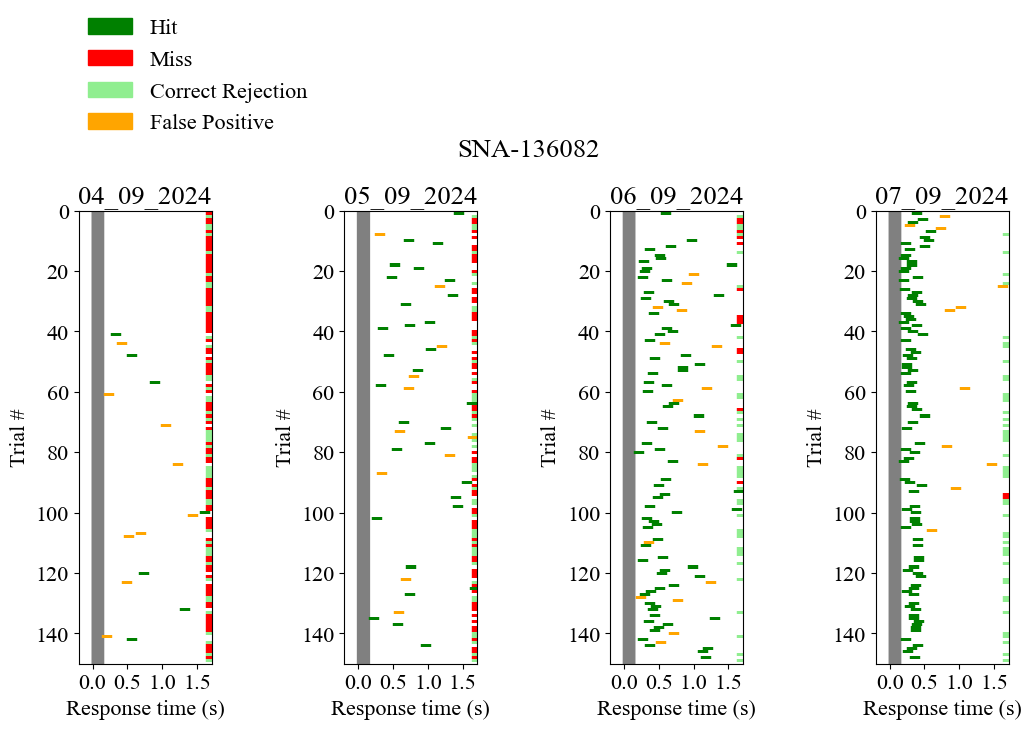

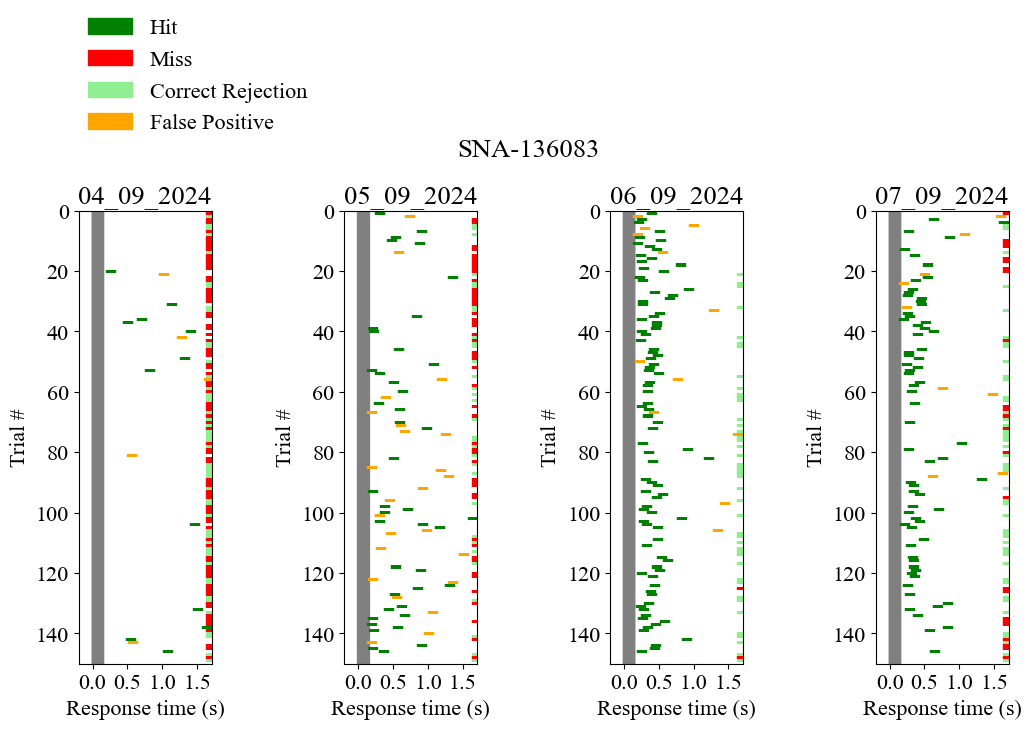

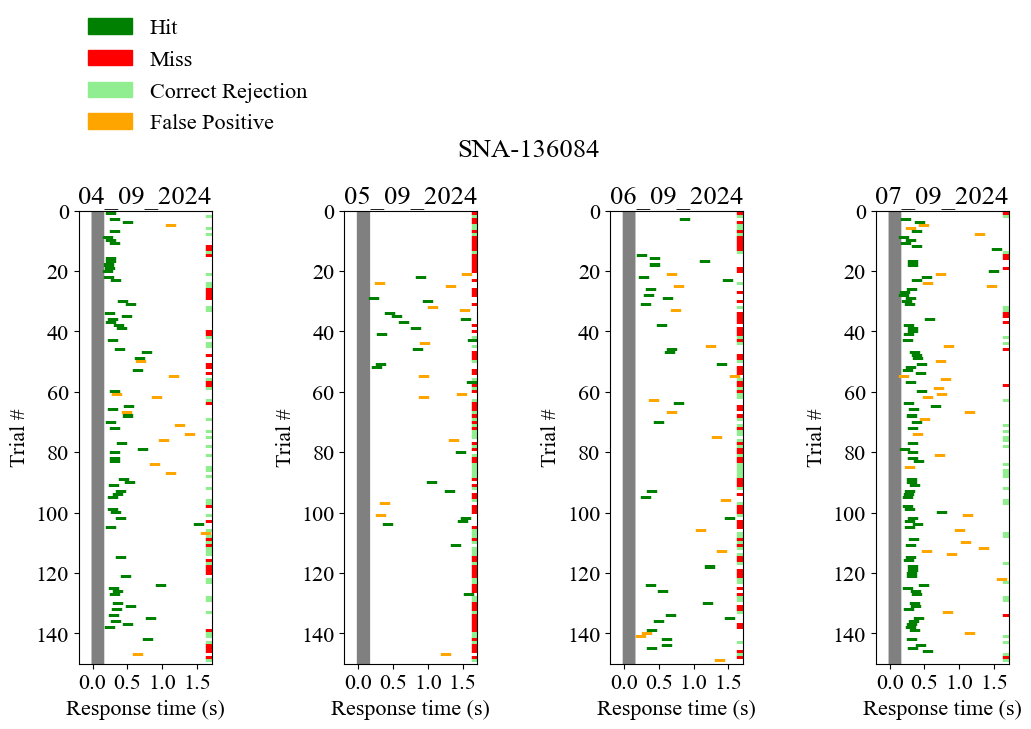

In [42]:
for mouse in aniso_data_pre:
    plot_raster_rt(mouse)

# CHANGE P_lick calculation to not just take a bin of the passed binsize trial, but take binsize/2 stim and catch trials. 
This way the number of catch and stim stays the same

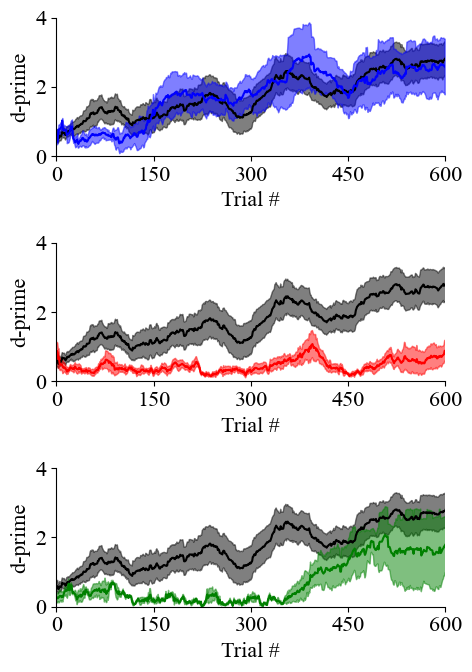

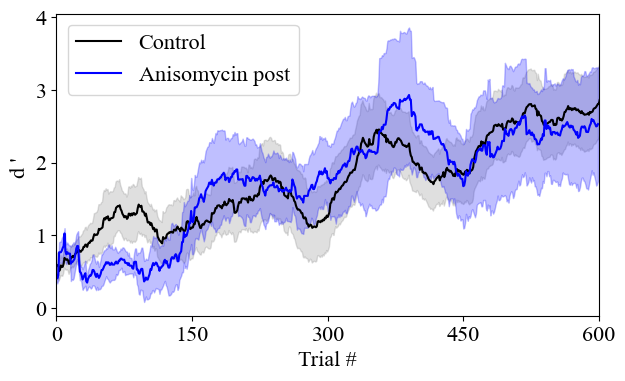

In [20]:
dpall = []
for mouse in ctrl_data:
    dplist = calc_d_prime(mouse, binsize=60)
    dpall.append(dplist)
dpall = extend_lists(dpall)
d_mean = np.mean(dpall, axis=0)

fig = plt.figure(figsize=(7,4))
plt.plot(d_mean, color='black', label='Control')

# Add SEM
d_std = np.std(dpall, axis=0)   
d_sem = d_std / np.sqrt(len(ctrl_data))
y_min = np.subtract(d_mean, d_sem)
y_max = np.add(d_mean, d_sem)
x = np.arange(0, len(d_mean), 1)
plt.fill_between(x, y_min, y_max, alpha=0.25, color='gray')


dp_ani = []
for mouse in aniso_data:
    dplist = calc_d_prime(mouse, binsize=60)
    dp_ani.append(dplist)
dp_ani = extend_lists(dp_ani)
d_mean = np.mean(dp_ani, axis=0)

plt.plot(d_mean, color='blue', label='Anisomycin post')

# Add SEM
d_std = np.std(dp_ani, axis=0)
d_sem = d_std / np.sqrt(len(aniso_data))
y_min = np.subtract(d_mean, d_sem)
y_max = np.add(d_mean, d_sem)
x = np.arange(0, len(d_mean), 1)
plt.fill_between(x, y_min, y_max, alpha=0.25, color='blue')


# dp_ani_pre = []
# for mouse in aniso_data_pre:
#     dplist = calc_d_prime(mouse, binsize=60)
#     dp_ani_pre.append(dplist)
# dp_ani_pre = extend_lists(dp_ani_pre)
# d_mean = np.mean(dp_ani_pre, axis=0)

# plt.plot(d_mean, color='lightblue', label='Anisomycin pre')

# # Add SEM
# d_std = np.std(dp_ani_pre, axis=0)
# d_sem = d_std / np.sqrt(len(aniso_data_pre))
# y_min = np.subtract(d_mean, d_sem)
# y_max = np.add(d_mean, d_sem)
# x = np.arange(0, len(d_mean), 1)
# plt.fill_between(x, y_min, y_max, alpha=0.25, color='lightblue')

plt.xlabel('Trial #')
plt.ylabel('d \' ')
plt.xticks([0,150,300,450,600])
plt.legend(loc='upper left')
plt.xlim([0,600])
plt.show()

Data will be concatenated; please check validity.


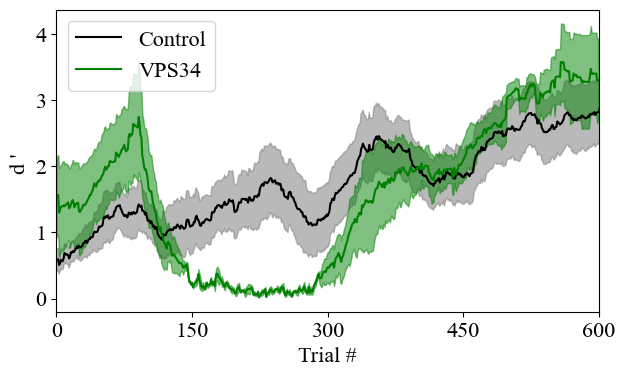

In [13]:


dpall = []
for mouse in ctrl_data:
    dplist = calc_d_prime(mouse, binsize=60)
    dpall.append(dplist)
dpall = extend_lists(dpall)
d_mean = np.mean(dpall, axis=0)

fig = plt.figure(figsize=(7,4))
plt.plot(d_mean, color='black', label='Control')

# Add SEM
d_std = np.std(dpall, axis=0)   
d_sem = d_std / np.sqrt(len(ctrl_data))
y_min = np.subtract(d_mean, d_sem)
y_max = np.add(d_mean, d_sem)
x = np.arange(0, len(d_mean), 1)
plt.fill_between(x, y_min, y_max, alpha=0.55, color='gray')


dp_vps = []
for mouse in vps_data:
    dplist = calc_d_prime(mouse, binsize=60)
    dp_vps.append(dplist)
dp_vps = extend_lists(dp_vps)
d_mean = np.mean(dp_vps, axis=0)

# plt.plot(d_mean, color='purple', label='CaMKII')
plt.plot(d_mean, color='green', label='VPS34')
# 

# Add SEM
d_std = np.std(dp_vps, axis=0)
d_sem = d_std / np.sqrt(len(vps_data))
y_min = np.subtract(d_mean, d_sem)
y_max = np.add(d_mean, d_sem)
x = np.arange(0, len(d_mean), 1)
plt.fill_between(x, y_min, y_max, alpha=0.5, color='green')

plt.xlabel('Trial #')
plt.ylabel('d \' ')
plt.xticks([0,150,300,450,600])
plt.legend(loc='upper left')
plt.xlim([0,600])
plt.show()

# P Lick by trials and sessions

16_10_2023
17_10_2023


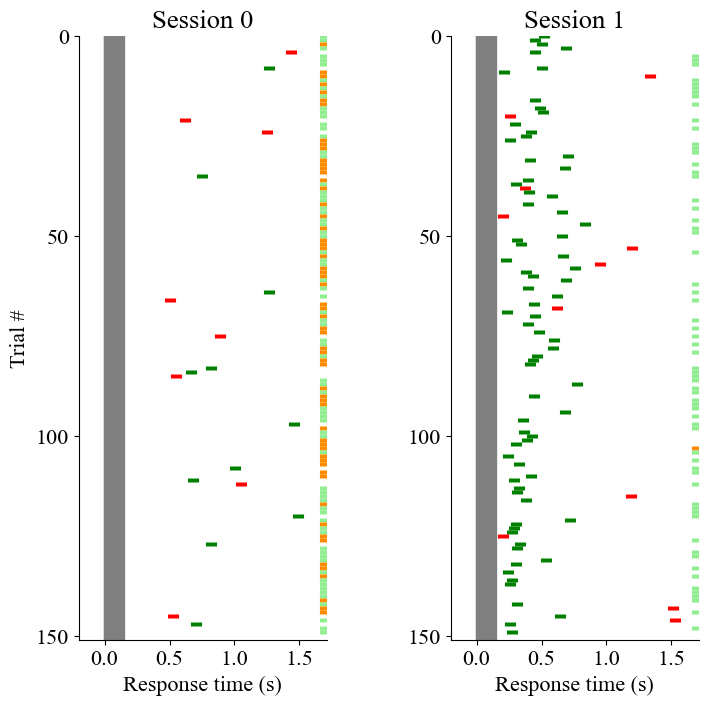

In [14]:
def plot_raster_rt(mouse_data, save=False, peak=False):
    ''' Creates a figure containing rasterplots of the trial response time.

        INPUT:
            mouse_data(Mouse_Data): Dataclass with attributes like id, sessions,.session_data and concatenated data
            save(bool): prompts the user for destination folder path
            peak(bool): if true only two session rasterplots will be created
        OUTPUT:
            raster_rt_plot(matplotlib.plt): either a plot is shown or saved
    '''
    # Check for peaking allowing the user to only see the plots of the first 2 sessions
    if peak:
        n_sessions = 2
    else:
        n_sessions = len(mouse_data.sessions)
    
    # ALTERED
    n_sessions = 2

    # Set figure basics 
    fig, axs = plt.subplots(1, n_sessions, figsize=(8, 8)) # Size plot according to the number of sessions
    plt.subplots_adjust(wspace=.5) 
    fig.patch.set_facecolor('white')
    
    # Create legend patches
    # gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')
    orange_patch = matplotlib.patches.Patch(color='red', label='False Positive')
    red_patch = matplotlib.patches.Patch(color='darkorange', label='Miss')
    green_patch = matplotlib.patches.Patch(color='green', label='Hit')
    lightgreen_patch = matplotlib.patches.Patch(color='lightgreen', label='Correct Rejection')
    
    # Get and plot data for every session
    for idx, session in enumerate(mouse_data.sessions):

        # Altered
        if idx == 1 or idx == 2:
            print(session)
            continue
        elif idx == 3: # for correct subplot
            idx = 1

        if peak and idx == n_sessions:
            break
        colors = []
        
        # For pairing only pair and mix data are important
        # if catch:
        select_data = mouse_data.session_data[session].loc[(mouse_data.session_data[session]['trialType'] == 2)|(mouse_data.session_data[session]['trialType'] == 1)|(mouse_data.session_data[session]['trialType'] == 'pairData')]        
        patches = [green_patch, red_patch, lightgreen_patch, orange_patch]
        
        # Aquire response time, xticks and datatype
        rt_full = select_data['response_t']
        x = np.arange(0, len(rt_full), 1) # Initiate x-axis for plotting
        rt = [[rt] for rt in rt_full] # plt.eventplot requires values as list to ascribe different offsets
        # dtype = [[dtype] for dtype in select_data['trialType']]

        # Pick right color
        for _, trial in select_data.iterrows():
            trial_success = trial['success']
            if trial['trialType'] == 2:
                if trial_success:
                    c = 'red'
                else:
                    c='lightgreen'
            elif trial['trialType'] == 1:
                if trial_success:
                    c = 'green'
                else:
                    c = 'darkorange'
                    
            colors.append(c)
            
        # Now the plot
        # If there are multiple sessions
        if len(mouse_data.sessions) > 1:
            for x in np.arange(0, 0.15, 0.001):
                axs[idx].axvline(x, color='gray')
            offset = np.arange(0, len(rt), 1)
            axs[idx].eventplot(rt, lineoffsets=offset, linewidth=8, colors=colors)
            axs[idx].set_xlim([-0.2, 1.71])
            axs[idx].invert_yaxis()
            axs[idx].set_ylim([151, 0])
            # axs[idx].set_yticks([0,25,50,75,100,125,150])
            axs[idx].set_yticks([0,50,100,150])
            axs[idx].set_xlabel('Response time (s)')
            axs[idx].set_title(f'Session {idx}')
            axs[idx].set_xticks(np.arange(0, 1.55, 0.5))
            # axs[0].legend(bbox_to_anchor=(0., 1.15, 1., .02), handles=patches, mode="expand", borderaxespad=0., ncol=1, frameon=False)
            axs[0].set_ylabel('Trial #')

            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['right'].set_visible(False)

    
    # Prompt user for destination folder path or show the plot
    if save:
        fname = input('What path do you want to save the .jpg to?')
        fig.savefig(fname+mouse_data.id+'.jpg', bbox_inches='tight')   
    else:   
        plt.show()
    return fig

matplotlib.rcParams.update({'font.size':20})
fig = plot_raster_rt(ctrl_data[4])
# fig.savefig(fname=savePath + 'raster_slim.svg', dpi=600)

01_03_2024
02_03_2024


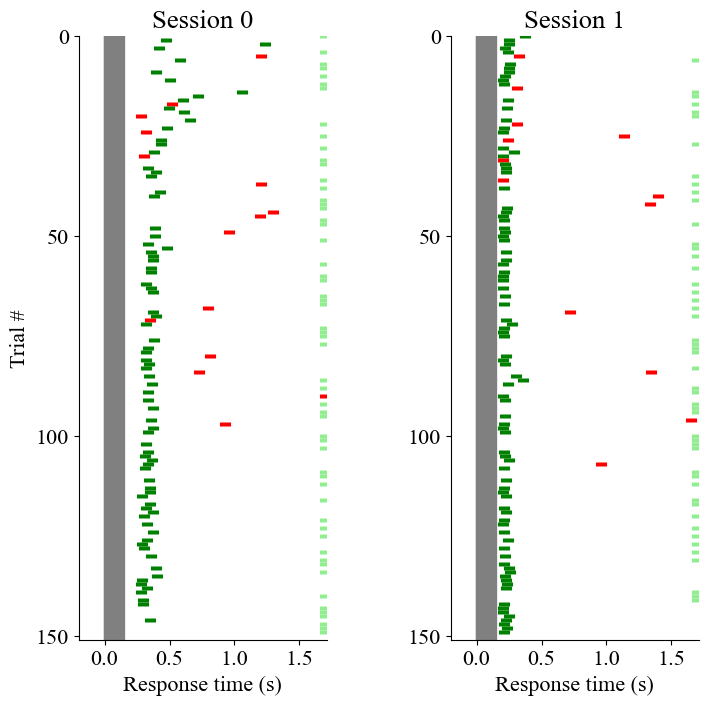

16_04_2024
17_04_2024


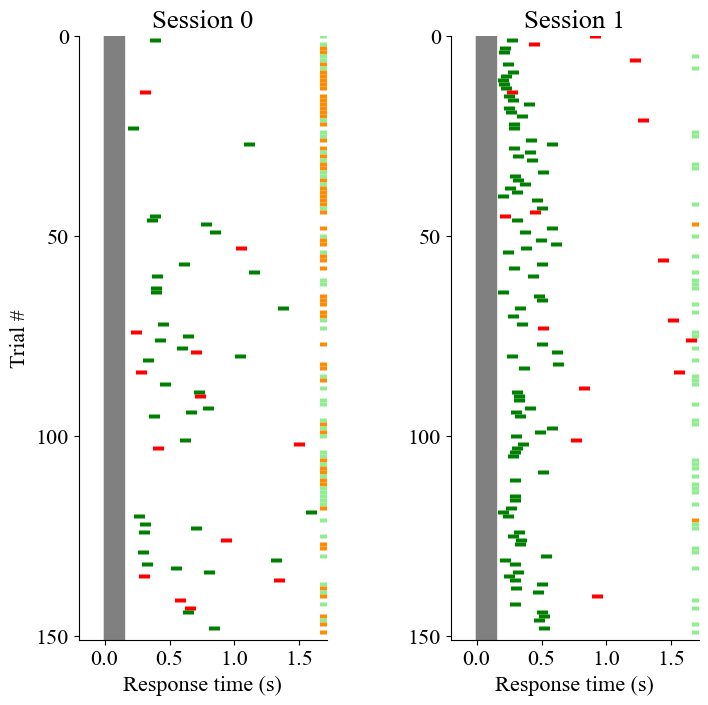

02_04_2024
03_04_2024


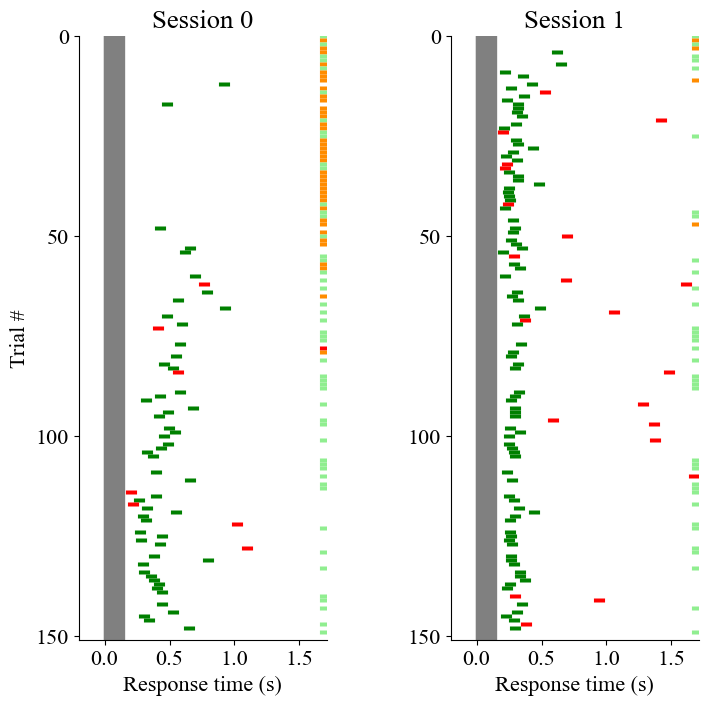

In [15]:
for mouse in vps_data:
    plot_raster_rt(mouse)

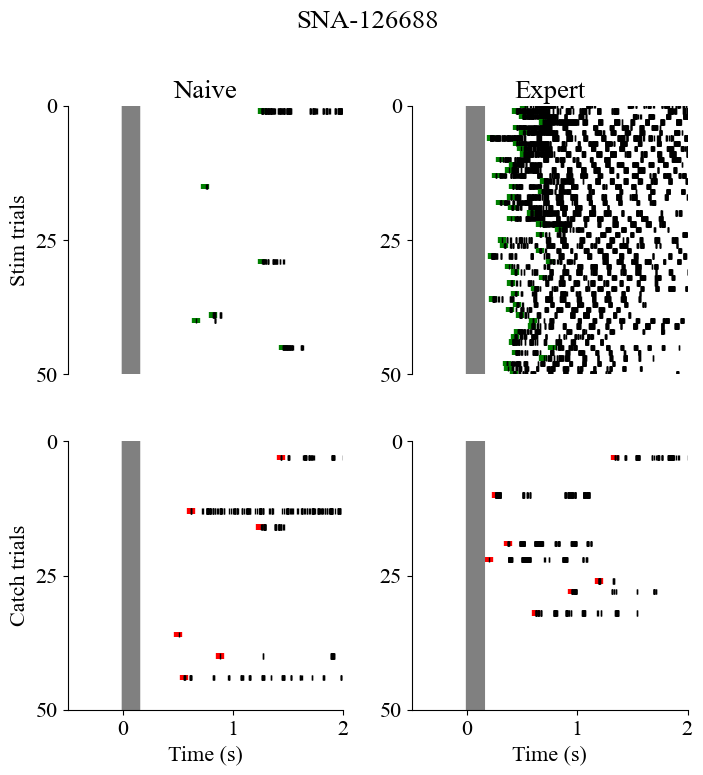

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np

def plot_lickPerformance(mouse_data, save=False, peak=False):
    '''docstring'''
    # Check for peaking allowing the user to only see the plots of the first 2 sessions
    if peak:
        n_sessions = 2
    else:
        n_sessions = len(mouse_data.sessions)

    # Limit to 2 sessions for plotting in 2x2 grid
    n_sessions = min(n_sessions, 2)

    # Set figure basics 
    fig, axs = plt.subplots(2, 2, figsize=(8, 8)) # 2x2 grid for subplots
    plt.subplots_adjust(wspace=0.25, hspace=0.25) 
    fig.patch.set_facecolor('white')
    fig.suptitle(str(mouse_data.id), y=1.0)

    # Create legend patches 
    gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')

    # Get and plot data for every session
    for idx, session in enumerate(mouse_data.sessions):
        if peak and idx == n_sessions:
            break
        if idx == 1 or idx == 2:
            continue
        if idx == 3:
            idx = 1

        for trialtype in [1, 2]:
            # Determine subplot location
            row = 0 if trialtype == 1 else 1
            col = idx
            colr = 'green' if trialtype == 1 else 'red'

            # Only specific trial types are necessary to plot here
            stimTrials = select_trialType(mouse_data.session_data[session], trialType=trialtype)

            # Get the licks, remove premature licks and zero on stim_t
            for i, trialData in enumerate(stimTrials.iterrows()):
                trialData = trialData[1] # Because the first value is the trialNumber, so slice
                
                # Ensure trialData['licks'] and trialData['stim_t'] are valid arrays
                licks = trialData['licks']
                stim_t = trialData['stim_t']
                
                if isinstance(licks, (list, np.ndarray)) and isinstance(stim_t, (int, float)):
                    # adjusted_licks = np.array(licks) - stim_t
                    adjusted_licks = np.array([lick for lick in licks if lick > stim_t + 0.2]) - stim_t
                
                    line_colors = [[colr] + ['black']*(len(adjusted_licks)-1)]
                    line_widths = [[6] + [1]*(len(adjusted_licks)-1)]

                    axs[row, col].eventplot(adjusted_licks, lineoffsets=i, colors=line_colors, linewidths=line_widths)

            # Now invert y-axis for readability and customise plot
            axs[row, col].invert_yaxis()
            axs[row, col].set_ylim([50, 0])
            axs[row, col].set_yticks([0, 25, 50])
            axs[row, col].set_xlim([-0.5, 2])
            axs[row, col].set_xticks([0, 1, 2])
            for x in np.arange(0, 0.15, 0.001):
                axs[row, col].axvline(x, color='gray')

            # Set title and labels
            if row == 0:
                axs[row, 0].set_title('Naive')
                axs[row, 1].set_title('Expert')
                axs[row, 0].set_ylabel('Stim trials')
                axs[row, 0].spines['top'].set_visible(False)
                axs[row, 0].spines['right'].set_visible(False)
                axs[row, 0].spines['bottom'].set_visible(False)
                axs[row, 1].spines['top'].set_visible(False)
                axs[row, 1].spines['right'].set_visible(False)
                axs[row, 1].spines['bottom'].set_visible(False)
                axs[row, col].set_xticks([])

            else:
                axs[row, 0].set_ylabel('Catch trials')
                axs[row, 0].spines['top'].set_visible(False)
                axs[row, 0].spines['right'].set_visible(False)
                # axs[row, 0].spines['bottom'].set_visible(False)
                axs[row, 1].spines['top'].set_visible(False)
                axs[row, 1].spines['right'].set_visible(False)
                # axs[row, 1].spines['bottom'].set_visible(False)
                axs[row, col].set_xlabel('Time (s)')


    # After all trials have been plotted adjust all plots
    plt.show()
    return fig

fig = plot_lickPerformance(ctrl_data[4])
# fig.savefig(fname=savePath + 'licks_all.svg', dpi=600)


# Lick frequency, how many of the licks occur during which timepoint?

## Current problems
* Licking during the stimulus is still not taken into account
* Aborted trials are not incorporated

## Solutions?
* Change the response time calculation to the first lick after stimulus, later use the update_aborted function in Mouse_Data to remove trials
* Get a vector of all licks? Appears computationally more intense, but might be nicer for alignment of neural data later.

C:\Users\miksc\AppData\Local\Temp\ipykernel_17292\4093331882.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


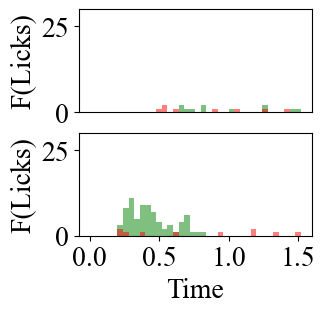

In [26]:
# Calculate and plot the RT during a mStim trial TODO Histogram should be the average occurance of all mice
def get_RTs(mouse_data):
    ''' Grabs the response time for all sessions in mouse_Data

    Returns tuple of lists: (fLick_stim, fLickcatch)
    '''
    stimRTs = []
    catchRTs = []

    # For each session
    for session in mouse_data.sessions:
        session_data = mouse_data.session_data[session]

        # Seperate on succes and select the stim and catch trials
        session_data = session_data.loc[session_data['success'] == True]
        stimTrials = select_trialType(session_data, 1)
        catchTrials = select_trialType(session_data, 2)

        # Of the sessions stim and catch trials get all rts
        stimRTs.append(stimTrials['response_t'])
        catchRTs.append(catchTrials['response_t'])
        
    return (stimRTs, catchRTs)


# We have extracted all the response times, now plot the fdensity of each session
def plotFLick(mouse_data):
    ''' docstring
    '''
    # Calc and unpack
    stimRTs, catchRTs = get_RTs(mouse_data)

    fig, axs = plt.subplots(2, 1, figsize=(3,3))

    i=0 
    for stimRT, catchRT in zip([stimRTs[0], stimRTs[-1]], [catchRTs[0], catchRTs[-1]]):
        stim_density = stats.gaussian_kde(stimRT)
        catch_density = stats.gaussian_kde(catchRT)

        x = np.arange(0, 1.54, 0.04)
        # plt.plot(x, stim_density(x), color='green')
        # plt.plot(x, catch_density(x), color='red')
        # plt.xlim([-1,2])

        axs[i].hist(stimRT, bins = x, color='green', alpha=0.5)
        axs[i].hist(catchRT, bins=x, color='red', alpha=0.5)
        axs[i].set_ylim([0, 30])
        axs[i].set_ylabel('F(Licks)')
        axs[-1].set_xlabel('Time')
        if i < 3:
            axs[0].set_xticks([])
            axs[-1].set_xticks([0, 0.5, 1, 1.5])
            # axs[i].set_xticks([])
        else:
            axs[i].set_xticks([0, 0.5, 1, 1.5])
        i+=1
        # fig.suptitle(mouse_data.id)
    fig.show()
    return fig

fig = plotFLick(ctrl_data[4])
# fig.savefig(fname=savePath + 'fLick.svg', dpi=600)


# Variance of response time
In order to determine if responses become more stereotyped we use multiple quantifications of this variance.
IMPORTANT the code below definitly overcomplicates things and is shit

### Coefficient of Variation (CV)
The Coefficient of Variation (CV) is a normalized measure of the dispersion of the data. It is defined as the ratio of the standard deviation to the mean and is often expressed as a percentage:

CV = sigma/mu * 100
CV is particularly useful when comparing the relative variability of data sets with different units or widely different means.

### Standard Error of the Mean (SEM)
The Standard Error of the Mean (SEM) normalizes the standard deviation by the square root of the sample size. It provides an estimate of how much the sample mean is expected to fluctuate due to sampling variability:

SEM = sigma/sqrt(n)


### Normalized Variance
While "normalized variance" is not a standard term, there are methods that can be considered as normalizing variance:

1. **Variance per Unit Range**:
   This normalizes the variance by the range of the data:


   Norm Var = sigma^2/range^2

   where Range is the difference between the maximum and minimum values in the data set.



In [ ]:
def get_RTvariances(mouse_data):
    ''' calculates all different types of variances in response time and returns it as a dict with keys the type of variance
    and the value a list of that variance value for each session.
    '''
    # Holder of the data as a list
    RTvariences = {'std':[], 
                   'var':[],
                   'cv':[],
                   'sem':[]}
    
    stimRTs, catchRTs = get_RTs(mouse_data)

    # Now calculate and append
    for i, RTs in enumerate(stimRTs):
        RTvariences['std'].append(np.std(RTs))
        RTvariences['var'].append(np.var(RTs))
        RTvariences['cv'].append(np.std(RTs)/np.mean(RTs) * 100)
        RTvariences['sem'].append(np.std(RTs)/np.sqrt(len(RTs)))        

    return RTvariences

def aggregate_RTvariances(data_list):
    '''
    Aggregates variance data from multiple mice into a single dictionary.
    
    Args:
    data_list (list): List of mouse data dictionaries.
    
    Returns:
    dict: A dictionary with aggregated variance data.
    '''
    aggregated_data = {'std': [], 
                       'var': [],
                       'cv': [],
                       'sem': []}

    for mouse_data in data_list:
        RTvariance = get_RTvariances(mouse_data)

        for key, values in RTvariance.items():
            aggregated_data[key].append(values)
    
    return aggregated_data

# Assuming ctrl_data is a list of mouse data
aggregated_data = aggregate_RTvariances(ctrl_data)

data = np.mean(aggregated_data['sem'], axis=0)
data_std = np.std(aggregated_data['sem'], axis=0)/len(aggregated_data['sem']) # TODO not even sure if what I am doing here is correct
fig = plt.figure(figsize=(3,3))
plt.bar(x=[0,1,2,3], height=data, color='gray', yerr=data_std, capsize=2)
plt.xticks([0,1,2,3])
plt.yticks([0, 0.04, 0.08])
plt.ylabel('SEM of RT')
plt.show()

fig.savefig(fname=savePath + 'sem_RT.svg', dpi=600)
# do_statistics(aggregated_data['sem'][0], aggregated_data['sem'][-1])


# Now that we have nested lists of values in a dictionary lets get the average of those values



TypeError: get_RTs() missing 1 required positional argument: 'trial_type'

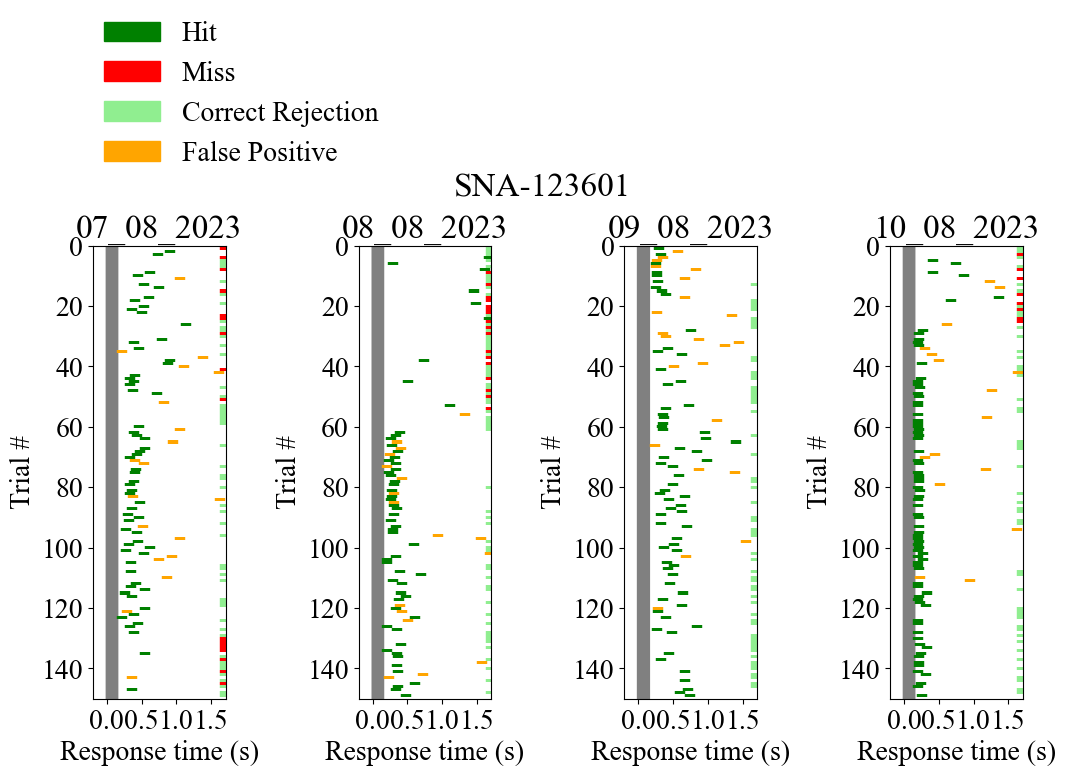

[0.49595652173913035, 0.4984936170212763, 0.49373749999999966, 0.48592708333333307, 0.4806595744680848, 0.4806595744680848, 0.4777999999999997, 0.4777999999999997, 0.4777999999999997, 0.47514489795918335, 0.47201458333333307, 0.47240638297872317, 0.47240638297872317, 0.47125833333333317, 0.46726458333333315, 0.4630874999999998, 0.4588857142857141, 0.4570519999999998, 0.453977551020408, 0.4550937499999998, 0.4550937499999998, 0.45552499999999974, 0.4575595744680847, 0.4549914893617018, 0.45006249999999964, 0.45006249999999964, 0.450124489795918, 0.4338551020408161, 0.4338551020408161, 0.4330739999999998, 0.4330739999999998, 0.4330739999999998, 0.4257224489795915, 0.4265583333333332, 0.4265583333333332, 0.42573191489361684, 0.4284270833333332, 0.4284270833333332, 0.4284270833333332, 0.418255319148936, 0.40832391304347815, 0.40832391304347815, 0.40832391304347815, 0.40832391304347815, 0.40841555555555537, 0.4101295454545453, 0.41046511627906956, 0.4121595238095235, 0.41083255813953456, 0.

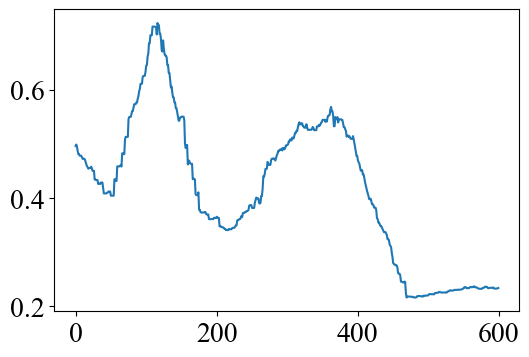

In [ ]:
def get_RTs(mouse_data, trialType, binsize=0):
    '''docstring
    '''
    # Inner function that grabs the average response time and SEM per session for a single Mouse_Data class
    
    def get_RT(mouse, trialType, binsize=0):
            ''' Grabs the response time for all sessions in mouse_Data

            Return dictionary with average RT and its SEM per session
            '''
            sessionRT_list = []

            # Check if a binsize was given, if Yes itterate through full.data and bin the response times 
            if binsize > 0:
                # Retrieve session data
                mouse = mouse.full_data

                # Add padding and randomize last rows
                last_rows = mouse.tail(int(binsize/2))
                last_rows = last_rows.sample(frac=1).reset_index(drop=True)
                mouse = pd.concat([mouse, last_rows, last_rows], ignore_index = True)

                # Calculate RT using a sliding window
                RT_avg_array = []
                RT_sem_array = []
                for start in range(len(mouse) - binsize):
                    bin_data = mouse.iloc[start:start + binsize]
                    trials = select_trialType(bin_data, trialType)
                    hits = trials.loc[trials['success'] == True] # NOTE if trialType is 2 then they are FPs
                    RT_avg_array.append(np.average(hits['response_t'], axis=0))
                    RT_sem_array.append(np.std(hits['response_t'], axis=0)/np.sqrt(len(hits)))

                return {'avg': RT_avg_array, 'sem': RT_sem_array}

            # In the normal case one should just get the average and sem per session
            else:
                # For each session
                for session in mouse.sessions:
                    session_data = mouse.session_data[session]

                    # Seperate on succes and select the stim and catch trials
                    session_data = session_data.loc[session_data['success'] == True]
                    trials = select_trialType(session_data, 1)


                    # Now calculate the average and SEM
                    avg = np.average(trials['response_t'], axis=0)
                    sem = np.std(trials['response_t'], axis=0) #/np.sqrt(len(trials['response_t']))
                    avg_sem_dict = {'avg': avg, 'sem':sem}
                    sessionRT_list.append(avg_sem_dict)
                return sessionRT_list


    # Check if a list was given or a single Mouse_Data class
    

    # If single Mouse_Data class, return the average response time per session 
    pass



        


TypeError: get_PLick() got an unexpected keyword argument 'binsize'

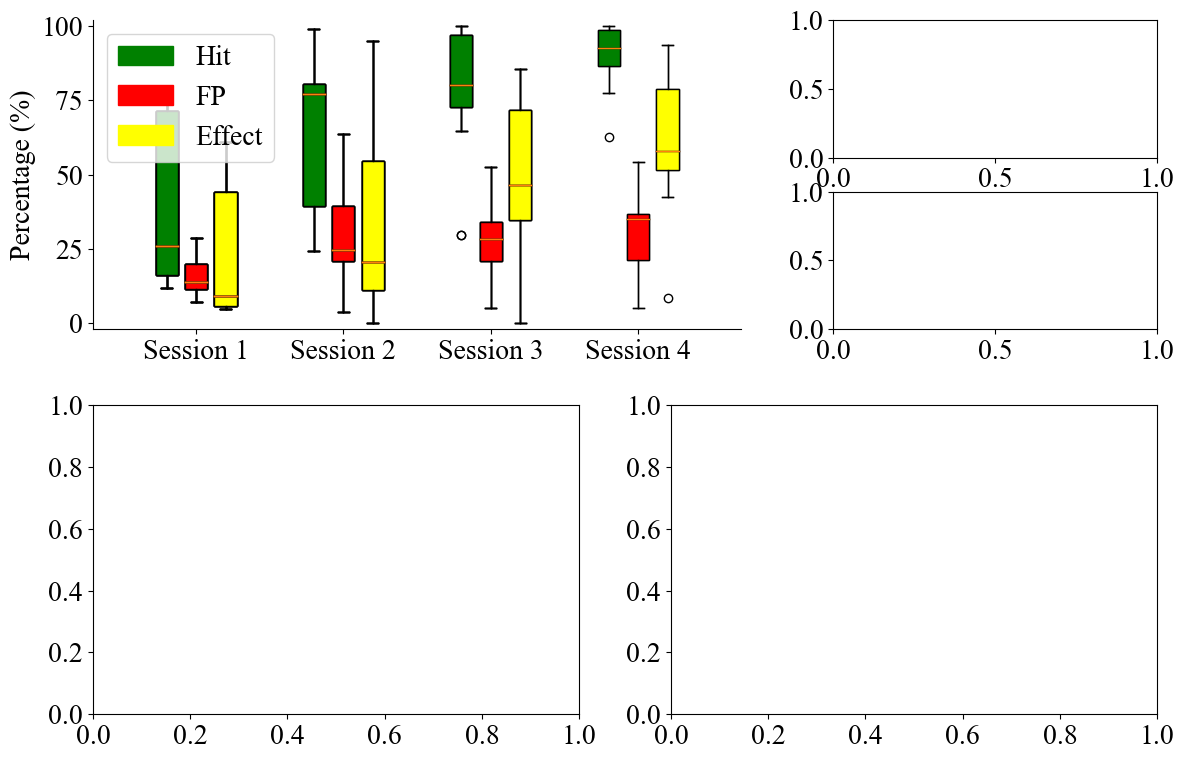